功能概述：
本项目的核心分析与建模脚本。利用微调后的 SBERT 模型将非结构化评论转化为语义向量，通过聚类构建特征，使用稀疏回归模型预测流水，并对关键特征进行可解释性分析。

输入：
- comments_preprocessed.pkl (清洗后的评论数据)
- ./data/character_info.csv (角色视频数据)
- ./data/bilibili_video_with_time_to_banner.csv (时间可用性标记)
- ./output/ (fine_tuning.py 训练好的 SBERT 模型权重)
输出：
- 模型性能评估报告 (MAE, R2, RMSE)
- 聚类语义解释 (关键词列表、典型评论)
- 稳健性检验结果图表

脚本执行流程：

1. 【语义向量化】
   - 加载微调后的 SBERT 模型，将所有合规评论转化为高维语义向量。

2. 【聚类与特征构造】
   - 使用球面K-Means 算法在语义球面上寻找 $K$ 个话题中心。
   - Voronoi 分割：将每条评论分配给最近的话题中心。
   - 特征生成：统计每个视频在各个话题聚类下的评论数量，并进行对数转换，构建回归特征矩阵 $X$。

3. 【LASSO 回归建模】
   - 建立预测模型：以“卡池 7 日流水”为因变量，以“聚类热度”+“控制变量”为自变量。
   - 交叉验证：使用 Repeated K-Fold CV 寻找最佳的聚类数 $K$ 和正则化系数 $\alpha$。
   - 评估指标：计算 Out-of-fold 的 MAE (平均绝对误差) 和 $R^2$。
   - > 实际上支持缺失值回归、点赞数加权热度、其他特征指标，但最终分析没有用到

4. 【稳健性检验】
   - Permutation Test：打乱标签检验模型是否显著优于随机猜测。
   - 蒙特卡罗模拟：
     (A) 随机聚类：检验语义聚类是否优于随机划分评论。
     (B) 随机中心：检验 K-Means 质心是否优于空间中随机选取的点。
   - 证明微调后的语义空间具有真实的预测信息。

5. 【可解释性分析】
   - 提取 LASSO 模型中权重最高的特征（即最能预测流水的评论话题）。
   - 利用 c-TF-IDF 算法提取该聚类的关键词。
   - 检索该聚类中心的最近邻评论，以此解释该话题的具体含义。

In [40]:
import os
import numpy as np
import pandas as pd
import faiss

from sentence_transformers import SentenceTransformer

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from typing import Optional
from joblib import Parallel, delayed


# -------------------------------------------------------
# 0. 辅助筛选函数（保留）
# -------------------------------------------------------
def filter_all_cols(all_cols):
    return all_cols

def filter_by_keyword(all_cols, keywords):
    return [c for c in all_cols if any(keyword in c for keyword in keywords)]

def filter_by_excluding_keyword(all_cols, keywords):
    return [c for c in all_cols if not any(keyword in c for keyword in keywords)]



def make_config_selectors_PV():
    """
    新版（无加权）：
      - 不考虑 proportion
      - 只比较 unweighted 的 overall / topics / PV-only
    """

    def excl_prop(cols):
        return filter_by_excluding_keyword(cols, ["proportion"])

    def unweighted_topics(cols):
        cols = excl_prop(cols)
        # 仅保留 *_topic*_comment_count
        return filter_by_keyword(cols, ["comment_count"])

    def unweighted_overall(cols):
        cols = excl_prop(cols)
        # 仅保留 *_total_comments（排除 weighted_*）
        base = filter_by_keyword(cols, ["total_comments"])
        return [c for c in base if "weighted_total_comments" not in c]

    def PV_only(cols):
        cols = excl_prop(cols)
        return filter_by_keyword(cols, ["PV"])

    selectors = {
        "controls_only": lambda cols: [],
        
        "controls+unweighted_PV_overall_heat": lambda cols:
            PV_only(unweighted_overall(cols)),

        # 注意：这里的 PV_only 作用在“topic 集”上，
        # 含义为“只用 PV 的 topic counts”
        "controls+unweighted_PV_only": lambda cols:
            PV_only(unweighted_topics(cols)),

        # # 可选：若你想恢复“overall + topics”组合对照
        # "controls+unweighted_overall_heat+topics": lambda cols:
        #     unweighted_overall(cols) + unweighted_topics(cols),
    }

    return selectors


# -------------------------------------------------------
# 2. availability 相关工具（保留你们现有逻辑）
# -------------------------------------------------------
def _merge_identical_availability_indicators(
    avail_wide: pd.DataFrame,
    video_types: list[str],
):
    indicator_cols = [f"is_{vt}_available" for vt in video_types]

    for col in indicator_cols:
        if col not in avail_wide.columns:
            avail_wide[col] = 0
    avail_wide[indicator_cols] = avail_wide[indicator_cols].astype(int)

    sig2vts = {}
    for vt in video_types:
        col = f"is_{vt}_available"
        sig = tuple(avail_wide[col].tolist())
        sig2vts.setdefault(sig, []).append(vt)

    vt_to_merged = {}
    merged_cols = []

    for sig, vts in sig2vts.items():
        vts = sorted(vts)
        if len(vts) == 1:
            vt = vts[0]
            col = f"is_{vt}_available"
            vt_to_merged[vt] = col
            merged_cols.append(col)
            continue

        merged_name = "is_" + "__".join(vts) + "_available"
        rep_col = f"is_{vts[0]}_available"
        avail_wide[merged_name] = avail_wide[rep_col].astype(int)

        for vt in vts:
            vt_to_merged[vt] = merged_name

        merged_cols.append(merged_name)

        for vt in vts:
            old = f"is_{vt}_available"
            if old in avail_wide.columns:
                avail_wide.drop(columns=[old], inplace=True)

    merged_cols_unique = []
    seen = set()
    for c in merged_cols:
        if c not in seen:
            merged_cols_unique.append(c)
            seen.add(c)

    return avail_wide, merged_cols_unique, vt_to_merged


def _load_video_availability_wide(
    banner_csv_path: str,
):
    banner = pd.read_csv(banner_csv_path)
    banner = banner[["character", "video_type", "time_to_banner_hours"]].copy()
    banner["video_type"] = banner["video_type"].astype(str)
    banner["available"] = (banner["time_to_banner_hours"].astype(float) >= 24).astype(int)

    video_types = sorted(banner["video_type"].unique().tolist())

    avail_wide = (
        banner.pivot_table(
            index="character",
            columns="video_type",
            values="available",
            aggfunc="max",
            fill_value=0,
        )
        .rename(columns=lambda vt: f"is_{vt}_available")
        .reset_index()
    )

    avail_wide, indicator_cols_unique, indicator_col_by_vt = _merge_identical_availability_indicators(
        avail_wide, video_types
    )

    return avail_wide, video_types, indicator_cols_unique, indicator_col_by_vt


# -------------------------------------------------------
# 3. NEW: comment-level 可用语料过滤
# -------------------------------------------------------
def filter_available_comments(
    df_filtered: pd.DataFrame,
    banner_csv_path: str = "data/bilibili_video_with_time_to_banner.csv",
):
    """
    仅保留可用的评论语料（用于 embedding + clustering + topic 聚合）。
    """
    banner = pd.read_csv(banner_csv_path)
    banner = banner[["character", "video_type", "time_to_banner_hours"]].copy()
    banner["video_type"] = banner["video_type"].astype(str)
    banner["available"] = (banner["time_to_banner_hours"].astype(float) >= 24).astype(int)

    tmp = df_filtered.copy()
    tmp["video_type"] = tmp["video_type"].astype(str)

    tmp = tmp.merge(
        banner[["character", "video_type", "available"]],
        on=["character", "video_type"],
        how="left",
    )
    tmp["available"] = tmp["available"].astype(int)
    tmp = tmp.loc[tmp["available"] == 1]
    tmp = tmp.loc[tmp["within_24h"] == 1]
    print(f"[filter_available_comments] 原始评论数={len(df_filtered)}, 可用评论数={len(tmp)}")

    return tmp.copy()

def restrict_comments_require_all_video_types(
    df_available: pd.DataFrame,
    embeddings_available: np.ndarray,
    banner_csv_path: str = "data/bilibili_video_with_time_to_banner.csv",
):
    """
    基于 banner availability（is_{vt}_available），只保留“在所有 required_video_types 上都可用”的角色，
    并同步裁剪 comment-level 的 df_available / embeddings_available。

    返回：
      df_av_restricted: 裁剪后的评论 df（只包含满足条件的角色）
      emb_av_restricted: 与之对齐的 embeddings
      allowed_characters: 满足条件的角色列表（后面 build_feature_cache_for_Ks 用）
    """
    # 复用与 build_feature_cache_for_Ks 相同的 availability 逻辑
    avail_wide, video_types, indicator_cols_unique, indicator_col_by_vt = _load_video_availability_wide(
        banner_csv_path
    )

    req_vts = video_types

    mask_char = pd.Series(True, index=avail_wide.index)

    for vt in req_vts:
        ind_col = indicator_col_by_vt.get(vt, None)
        mask_char &= (avail_wide[ind_col].astype(int) == 1)

    allowed_chars = avail_wide.loc[mask_char, "character"].astype(df_available["character"].dtype)
    allowed_set = set(allowed_chars.tolist())

    row_mask = df_available["character"].isin(allowed_set).to_numpy()
    df_av_restricted = df_available.loc[row_mask].reset_index(drop=True)
    emb_av_restricted = embeddings_available[row_mask]

    print(
        "[restrict_comments_require_all_video_types] 角色总数="
        f"{avail_wide['character'].nunique()}, 满足条件角色数={len(allowed_set)}；"
        f"裁剪后评论数={len(df_av_restricted)} / {len(df_available)}"
    )

    return df_av_restricted, emb_av_restricted, sorted(allowed_set)

# -------------------------------------------------------
# 4. topic 特征生成（移除 w / weighted）
# -------------------------------------------------------
def generate_topic_features(
    embeddings: np.ndarray,
    df_labels: pd.DataFrame,
    K: int = 50,
    include_proportions: bool = True,
    verbose: bool = True,
    train_embeddings: Optional[np.ndarray] = None,
    centroids: Optional[np.ndarray] = None,
    df_for_clustering: Optional[pd.DataFrame] = None,
    cluster_video_types: Optional[list[str]] = None,
):
    """
    无加权版本（训练/分析可分离）：
      - 若 centroids=None：
          使用 train_embeddings（若提供）否则用 embeddings 训练聚类
      - 不管训练用谁，labels/聚合都基于 embeddings + df_labels
      - 特征只生成：
          * topic comment_count
          * overall total_comments
        （proportion 逻辑保留开关，但建议默认关）
    需要 df_labels 至少包含：
      ['character', 'video_type']
    """

    # 1) 训练阶段（可用全量 embeddings）
    if centroids is None:
        emb_train = train_embeddings if train_embeddings is not None else embeddings
        if cluster_video_types is not None:
            df_train = df_labels if train_embeddings is None else df_for_clustering
            mask = df_train["video_type"].astype(str).isin(cluster_video_types).to_numpy()
            emb_train = emb_train[mask]
        d = emb_train.shape[1]

        index_ip = faiss.IndexFlatIP(d)
        clu = faiss.Clustering(d, K)
        clu.verbose = verbose
        clu.spherical = True

        clu.train(emb_train, index_ip)
        centroids = faiss.vector_to_array(clu.centroids).reshape(K, d)
    else:
        d = centroids.shape[1]

    # 2) 赋标签阶段（用分析集 embeddings）
    index_cent = faiss.IndexFlatIP(d)
    index_cent.add(centroids)
    _, I = index_cent.search(embeddings, 1)
    labels = I.ravel()
    counts = np.bincount(labels, minlength=K)

    feature_data = df_labels[["character", "video_type"]].copy()
    feature_data["topic"] = labels

    # 仅 comment_count
    video_topic_stats = (
        feature_data
        .groupby(["character", "video_type", "topic"], as_index=False)
        .agg(comment_count=("topic", "size"))
    )

    wide_topic = video_topic_stats.pivot_table(
        index="character",
        columns=["video_type", "topic"],
        values=["comment_count"],
        fill_value=0.0,
    )
    wide_topic.columns = [
        f"{vt}_topic{t}_{m}"
        for (m, vt, t) in wide_topic.columns.to_flat_index()
    ]
    wide_topic = wide_topic.reset_index()

    # overall total_comments
    overall_video_stats = (
        feature_data
        .groupby(["character", "video_type"], as_index=False)
        .agg(total_comments=("topic", "size"))
    )

    wide_overall = overall_video_stats.pivot_table(
        index="character",
        columns="video_type",
        values=["total_comments"],
        fill_value=0.0,
    )
    wide_overall.columns = [
        f"{vt}_{m}"
        for (m, vt) in wide_overall.columns.to_flat_index()
    ]
    wide_overall = wide_overall.reset_index()

    wide_features = pd.merge(wide_topic, wide_overall, on="character", how="inner")

    # proportion 仍可选
    if include_proportions:
        total_stats_for_prop = (
            feature_data
            .groupby(["character", "video_type"])
            .agg(total_comments_for_prop=("topic", "size"))
            .reset_index()
        )
        fd = pd.merge(feature_data, total_stats_for_prop, on=["character", "video_type"])
        fd["unweighted_proportion"] = 1.0 / (fd["total_comments_for_prop"] + 1e-9)

        topic_prop = (
            fd.groupby(["character", "video_type", "topic"], as_index=False)
              .agg(unweighted_proportion=("unweighted_proportion", "sum"))
        )

        wide_prop = topic_prop.pivot_table(
            index="character",
            columns=["video_type", "topic"],
            values=["unweighted_proportion"],
            fill_value=0.0
        )
        wide_prop.columns = [
            f"{vt}_topic{t}_{m}"
            for (m, vt, t) in wide_prop.columns.to_flat_index()
        ]
        wide_prop = wide_prop.reset_index()

        wide_features = pd.merge(wide_features, wide_prop, on="character", how="inner")

    clustering_results = {"labels": labels, "centroids": centroids, "counts": counts}
    return wide_features, clustering_results
# -------------------------------------------------------
# 5. build_feature_cache_for_Ks（保持结构性缺失，但改为无加权聚类）
# -------------------------------------------------------
def build_feature_cache_for_Ks(
    embeddings,
    df_filtered,
    K_list,
    character_info_csv,
    include_proportions=False,
    banner_csv_path="data/bilibili_video_with_time_to_banner.csv",
    embeddings_for_clustering=None,
    df_for_clustering=None,
    cluster_video_types=None,
    character_filter=None,
):
    """
    无加权 + 结构性缺失版（训练/分析分离）：
      1) availability indicator（合并完全一致列）
      2) 对不可用 vt：将 vt 前缀 topic/overall 列置 NaN
      3) topic/overall log1p 保留 NaN
      4) X = topic_cols + BASE_CONTROLS + availability_cols_unique
      5) control_vars 仅返回 BASE_CONTROLS

    关键：
      - embeddings: 用于“分析/聚合”的评论 embeddings（需与 df_filtered 行对齐）
      - embeddings_for_clustering: 用于“训练聚类”的 embeddings（可为全量）
    """
    ci = pd.read_csv(character_info_csv)
    ci_base = ci[["character", "gender", "pool_index", "start_date", "7day_revenue"]].copy()

    date_time = pd.to_datetime(ci_base["start_date"]).astype("int64")
    ci_base["time_num"] = date_time - date_time.min()

    gender_dum = pd.get_dummies(ci_base["gender"], prefix="gender", drop_first=True)

    avail_wide, video_types, indicator_cols_unique, indicator_col_by_vt = _load_video_availability_wide(
        banner_csv_path
    )

    char_meta = pd.concat(
        [
            ci_base[["character", "pool_index", "time_num", "start_date", "7day_revenue"]],
            gender_dum,
        ],
        axis=1,
    )

    char_meta = pd.merge(char_meta, avail_wide, on="character", how="left")
    for col in indicator_cols_unique:
        if col not in char_meta.columns:
            char_meta[col] = 0
    char_meta[indicator_cols_unique] = char_meta[indicator_cols_unique].astype(int)

    if character_filter is not None:
        char_meta = char_meta[char_meta["character"].isin(character_filter)].reset_index(drop=True)
    BASE_CONTROL_VARIABLES = ["pool_index", "time_num"] + list(gender_dum.columns)

    features_by_K = {}

    for K in K_list:
        wide_features_df, clustering_results = generate_topic_features(
            embeddings=embeddings,
            df_labels=df_filtered,
            K=K,
            include_proportions=include_proportions,
            verbose=False,
            train_embeddings=embeddings_for_clustering,
            df_for_clustering=df_for_clustering,
            cluster_video_types=cluster_video_types,
        )
        centroids = clustering_results["centroids"]
        chars_in_wide = set(wide_features_df["character"].astype(str))
        char_meta_together = char_meta[
            char_meta["character"].astype(str).isin(chars_in_wide)
        ].copy()

        dfm = pd.merge(wide_features_df, char_meta_together, on="character", how="right")

        meta_cols = [
            "character",
            "pool_index",
            "time_num",
            "start_date",
            "7day_revenue",
        ] + list(gender_dum.columns) + indicator_cols_unique

        topic_cols = [c for c in dfm.columns if c not in meta_cols]

        # 注入结构性缺失
        for vt in video_types:
            ind = indicator_col_by_vt.get(vt, None)
            if ind is None or ind not in dfm.columns:
                continue
            vt_cols = [c for c in topic_cols if c.startswith(f"{vt}_")]
            if vt_cols:
                dfm.loc[dfm[ind] == 0, vt_cols] = np.nan

        if topic_cols:
            dfm[topic_cols] = np.log1p(dfm[topic_cols])

        X = pd.concat(
            [
                dfm[topic_cols],
                dfm[BASE_CONTROL_VARIABLES],
                dfm[indicator_cols_unique],
            ],
            axis=1,
        )

        y_raw = dfm["7day_revenue"].astype(float)
        y_log = np.log1p(y_raw)


        df_info = dfm[["character", "start_date"]].copy()

        features_by_K[K] = {
            "X": X,
            "y_raw": y_raw,
            "y_log": y_log,
            "df_info": df_info,
            "control_vars": BASE_CONTROL_VARIABLES,
            "topic_cols": topic_cols,
            "video_types": video_types,
            "availability_cols_unique": indicator_cols_unique,
            "availability_col_by_vt": indicator_col_by_vt,
            "centroids": centroids,
        }

    return features_by_K
# -------------------------------------------------------
# 6. 两阶段手动 LASSO CV（保持你们当前实现）
# -------------------------------------------------------
def _fit_one_alpha_over_splits_metrics(
    alpha,
    X_sub,
    y_log,
    splits,
    standardize_y: bool = True,
):
    split_mae = []
    split_rmse = []

    X_vals = X_sub.values
    y_vals = y_log.values.astype(float)

    for train_idx, test_idx in splits:
        X_train = X_vals[train_idx]
        y_train = y_vals[train_idx]
        X_test = X_vals[test_idx]
        y_test = y_vals[test_idx]

        if standardize_y:
            y_mu = float(np.mean(y_train))
            y_sd = float(np.std(y_train))
            if y_sd == 0.0:
                y_sd = 1.0
            y_train_fit = (y_train - y_mu) / y_sd
        else:
            y_mu, y_sd = 0.0, 1.0
            y_train_fit = y_train

        est = make_pipeline(
            SimpleImputer(strategy="mean"),
            StandardScaler(),
            Lasso(alpha=float(alpha), max_iter=10000)
        )
        est.fit(X_train, y_train_fit)

        y_pred_fit = est.predict(X_test)

        # 还原到原 y 尺度
        y_pred = (y_pred_fit * y_sd + y_mu) if standardize_y else y_pred_fit

        mae = mean_absolute_error(y_test, y_pred)
        rmse = float(np.sqrt(mean_squared_error(y_test, y_pred)))

        split_mae.append(float(mae))
        split_rmse.append(float(rmse))

    return {
        "alpha": float(alpha),
        "split_mae": np.asarray(split_mae, dtype=float),
        "split_rmse": np.asarray(split_rmse, dtype=float),
    }


def _fit_best_alpha_collect(
    best_alpha,
    X_sub,
    y_log,
    splits,
    standardize_y: bool = True,
):
    split_coefs = []
    split_test_idx = []
    split_y_pred = []

    X_vals = X_sub.values
    y_vals = y_log.values.astype(float)

    for train_idx, test_idx in splits:
        X_train = X_vals[train_idx]
        y_train = y_vals[train_idx]
        X_test = X_vals[test_idx]

        if standardize_y:
            y_mu = float(np.mean(y_train))
            y_sd = float(np.std(y_train))
            if y_sd == 0.0:
                y_sd = 1.0
            y_train_fit = (y_train - y_mu) / y_sd
        else:
            y_mu, y_sd = 0.0, 1.0
            y_train_fit = y_train

        est = make_pipeline(
            SimpleImputer(strategy="mean"),
            StandardScaler(),
            Lasso(alpha=float(best_alpha), max_iter=10000)
        )
        est.fit(X_train, y_train_fit)

        y_pred_fit = est.predict(X_test)
        y_pred = (y_pred_fit * y_sd + y_mu) if standardize_y else y_pred_fit

        coef = est.named_steps["lasso"].coef_.astype(float)

        split_coefs.append(coef)
        split_test_idx.append(test_idx)
        split_y_pred.append(y_pred.astype(float))

    return {
        "split_coefs": split_coefs,
        "split_test_idx": split_test_idx,
        "split_y_pred": split_y_pred,
    }

def run_model_selection_grid(
    features_by_K,
    config_selectors,
    alpha_grid,
    n_splits=5,
    random_state=42,
    n_repeats=3,
    n_jobs=-1,
    y_mode="log",
    save_path="results/model_selection_grid.csv",
):
    any_K = next(iter(features_by_K.keys()))
    n_samples = features_by_K[any_K]["X"].shape[0]
    if n_samples < n_splits:
        raise ValueError(f"样本数 {n_samples} < n_splits={n_splits}，请下调 n_splits。")

    cv = RepeatedKFold(
        n_splits=n_splits,
        n_repeats=n_repeats,
        random_state=random_state
    )
    baseline_configs = {
        "controls_only",
        "controls+unweighted_overall_heat",
        "controls+unweighted_PV_overall_heat",
    }
    baseline_anchor_K = sorted(features_by_K.keys())[0]

    rows = []
    best_artifacts_by_model = {}

    print(f"\n[run_model_selection_grid] ===== 开始模型比较 =====")
    print(
        f"[run_model_selection_grid] alpha_grid: min={np.min(alpha_grid)}, "
        f"max={np.max(alpha_grid)}, len={len(alpha_grid)}"
    )
    print(
        f"[run_model_selection_grid] n_splits={n_splits}, "
        f"n_repeats={n_repeats}, total_splits={n_splits * n_repeats}, "
        f"random_state={random_state}, n_jobs={n_jobs}"
    )

    for K in sorted(features_by_K.keys()):
        pack = features_by_K[K]
        X_full = pack["X"]
        if y_mode == "raw":
            y_log = pack["y_raw"]
        else:
            y_log = pack["y_log"]
        topic_cols = pack["topic_cols"]
        control_vars = pack["control_vars"]

        y_vals = y_log.values.astype(float)
        y_mean = float(y_vals.mean())
        sse0 = float(((y_vals - y_mean) ** 2).sum())

        for config_name, selector_fn in config_selectors.items():
            if (config_name in baseline_configs) and (K != baseline_anchor_K):
                continue
            # print(f"\n[run_model_selection_grid]   -> K={K}, config={config_name}")

            selected_topic_cols = selector_fn(topic_cols)

            base_controls = control_vars

            used_vts = sorted({c.split("_", 1)[0] for c in selected_topic_cols})

            indicator_col_by_vt = pack.get("availability_col_by_vt", {})
            avail_cols_for_config = []
            seen = set()
            for vt in used_vts:
                col = indicator_col_by_vt.get(vt, None)
                if col is not None and col not in seen:
                    avail_cols_for_config.append(col)
                    seen.add(col)

            final_cols = base_controls + avail_cols_for_config + selected_topic_cols

            X_sub = X_full[final_cols]
            feature_names = list(X_sub.columns)

            splits = list(cv.split(X_sub, y_log))
            n_cv_splits_total = len(splits)

            fold_sizes = np.asarray([len(test_idx) for _, test_idx in splits], dtype=float)
            fold_sizes_rep = fold_sizes.reshape(n_repeats, n_splits)

            # Stage A
            alpha_results = Parallel(n_jobs=n_jobs)(
                delayed(_fit_one_alpha_over_splits_metrics)(
                    alpha=a,
                    X_sub=X_sub,
                    y_log=y_log,
                    splits=splits,
                )
                for a in alpha_grid
            )

            n_candidates = len(alpha_grid)
            split_mae_all = np.empty((n_cv_splits_total, n_candidates), dtype=float)
            split_rmse_all = np.empty((n_cv_splits_total, n_candidates), dtype=float)

            for j, res in enumerate(alpha_results):
                split_mae_all[:, j] = res["split_mae"]
                split_rmse_all[:, j] = res["split_rmse"]

            split_mae_rep = split_mae_all.reshape(n_repeats, n_splits, n_candidates)
            split_rmse_rep = split_rmse_all.reshape(n_repeats, n_splits, n_candidates)

            pooled_mae_rep = np.empty((n_repeats, n_candidates), dtype=float)
            pooled_rmse_rep = np.empty((n_repeats, n_candidates), dtype=float)
            pooled_r2_rep = np.empty((n_repeats, n_candidates), dtype=float)

            for r in range(n_repeats):
                fs = fold_sizes_rep[r]
                n_total_r = fs.sum()

                pooled_mae_rep[r] = (split_mae_rep[r] * fs[:, None]).sum(axis=0) / n_total_r

                sse_r = ((split_rmse_rep[r] ** 2) * fs[:, None]).sum(axis=0)

                pooled_rmse_rep[r] = np.sqrt(sse_r / n_total_r)

                pooled_r2_rep[r] = 1.0 - sse_r / sse0

            pooled_mae_mean = pooled_mae_rep.mean(axis=0)
            pooled_rmse_mean = pooled_rmse_rep.mean(axis=0)
            pooled_r2_mean = pooled_r2_rep.mean(axis=0)

            if n_repeats > 1:
                pooled_mae_std = pooled_mae_rep.std(axis=0, ddof=1)
                pooled_rmse_std = pooled_rmse_rep.std(axis=0, ddof=1)
                pooled_r2_std = pooled_r2_rep.std(axis=0, ddof=1)
            else:
                pooled_mae_std = np.zeros_like(pooled_mae_mean)
                pooled_rmse_std = np.zeros_like(pooled_rmse_mean)
                pooled_r2_std = np.zeros_like(pooled_r2_mean)

            best_idx = int(np.argmin(pooled_mae_mean))
            best_alpha = float(alpha_grid[best_idx])

            row = {
                "K": K,
                "config_name": config_name,
                "best_alpha": best_alpha,
                "n_features_total": X_sub.shape[1],
                "n_topic_features": len(selected_topic_cols),
                "cv_mae_mean": float(pooled_mae_mean[best_idx]),
                "cv_mae_std": float(pooled_mae_std[best_idx]),
                "cv_rmse_mean": float(pooled_rmse_mean[best_idx]),
                "cv_rmse_std": float(pooled_rmse_std[best_idx]),
                "cv_r2_mean": float(pooled_r2_mean[best_idx]),
                "cv_r2_std": float(pooled_r2_std[best_idx]),
            }
            rows.append(row)

            # Stage B
            best_pack = _fit_best_alpha_collect(
                best_alpha=best_alpha,
                X_sub=X_sub,
                y_log=y_log,
                splits=splits,
            )

            N = X_sub.shape[0]
            oof_preds_by_repeat = []
            for r in range(n_repeats):
                oof = np.full(N, np.nan, dtype=float)
                for k in range(n_splits):
                    split_id = r * n_splits + k
                    test_idx = best_pack["split_test_idx"][split_id]
                    y_pred = best_pack["split_y_pred"][split_id]
                    oof[test_idx] = y_pred
                oof_preds_by_repeat.append(oof)

            best_artifacts_by_model[(K, config_name)] = {
                "best_alpha": best_alpha,
                "feature_names": feature_names,
                "split_coefs": best_pack["split_coefs"],
                "split_test_idx": best_pack["split_test_idx"],
                "split_y_pred": best_pack["split_y_pred"],
                "oof_preds_by_repeat": oof_preds_by_repeat,
            }

    summary_df = pd.DataFrame(rows).sort_values(
        by=["cv_mae_mean", "cv_rmse_mean"],
        na_position="last"
    ).reset_index(drop=True)

    if not os.path.exists(os.path.dirname(save_path)):
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
    summary_df.to_csv(save_path, index=False)

    print(f"\n[run_model_selection_grid] ===== 结束模型比较，结果已保存到: {save_path} =====")

    return summary_df, best_artifacts_by_model

# -------------------------------------------------------
# 7. 主流程（无加权 + 可用语料聚类）
# -------------------------------------------------------
if __name__ == "__main__":
    df = pd.read_pickle("comments_preprocessed.pkl")

    df = df.reset_index(drop=True).copy()
    df["__row_id__"] = np.arange(len(df), dtype=int)

    # 2) 全量评论用于聚类训练
    train_texts_all = df["评论内容"].tolist()

    # 3) 可用评论用于 topic 计数聚合
    df_available = filter_available_comments(
        df,
        banner_csv_path="data/bilibili_video_with_time_to_banner.csv",
    )

    # 4) 生成/加载“全量评论”的 embeddings（命名也改清楚）
    try:
        print("尝试加载已存在的全量embeddings...")
        embeddings_all = np.load("emb_train_all_unweighted.npy").astype("float32")
    except FileNotFoundError:
        print("未找到全量embeddings，开始重新计算（全量语料 + 无加权）...")
        st_model = SentenceTransformer(
            "./output/tsdae-bert-20251207_104308/emoji_base_st",
            device="cuda"
        )
        embeddings_all = st_model.encode(
            train_texts_all,
            batch_size=256,
            normalize_embeddings=True,
            show_progress_bar=True
        ).astype("float32")
        np.save("emb_train_all_unweighted.npy", embeddings_all)

    # 5) 只保留一次归一化（若 encode 已 normalize，这里也不会出大问题）
    faiss.normalize_L2(embeddings_all)

    # 6) 从“全量 embeddings”中切出“可用评论 embeddings”
    avail_ids = df_available["__row_id__"].to_numpy(dtype=int)
    embeddings_available = embeddings_all[avail_ids]

    # 7) K 候选集合
    K_list = range(2, 51)

    # 8) 角色级特征缓存
    features_by_K = build_feature_cache_for_Ks(
        embeddings=embeddings_available,
        df_filtered=df_available,
        K_list=K_list,
        character_info_csv="data/character_info.csv",
        include_proportions=False,
        banner_csv_path="data/bilibili_video_with_time_to_banner.csv",
        embeddings_for_clustering=embeddings_available,
        # df_for_clustering=df,
        # cluster_video_types=["角色PV"]
    )
    # configs
    config_selectors = make_config_selectors_PV()

    # alpha 网格
    # alpha_grid = np.logspace(-2, -0.5, 10)
    alpha_grid = [0.15]

    # 运行模型比较
    model_selection_df, best_artifacts_by_model = run_model_selection_grid(
        features_by_K=features_by_K,
        config_selectors=config_selectors,
        alpha_grid=alpha_grid,
        n_splits=5,
        n_repeats=10,
        random_state=42,
        n_jobs=-1,
        save_path="results/model_selection_baseline_PV.csv",
    )

    print(model_selection_df.head().to_string(index=False))
            


[filter_available_comments] 原始评论数=1261033, 可用评论数=709969
尝试加载已存在的全量embeddings...

[run_model_selection_grid] ===== 开始模型比较 =====
[run_model_selection_grid] alpha_grid: min=0.15, max=0.15, len=1
[run_model_selection_grid] n_splits=5, n_repeats=10, total_splits=50, random_state=42, n_jobs=-1

[run_model_selection_grid] ===== 结束模型比较，结果已保存到: results/model_selection_baseline_PV.csv =====
 K                 config_name  best_alpha  n_features_total  n_topic_features  cv_mae_mean  cv_mae_std  cv_rmse_mean  cv_rmse_std  cv_r2_mean  cv_r2_std
18 controls+unweighted_PV_only        0.15                22                18     0.337794    0.007703      0.401879     0.007482    0.636756   0.013541
22 controls+unweighted_PV_only        0.15                26                22     0.341001    0.010076      0.406602     0.009945    0.628083   0.018223
14 controls+unweighted_PV_only        0.15                18                14     0.343314    0.010584      0.410572     0.010277    0.620775   0.019083


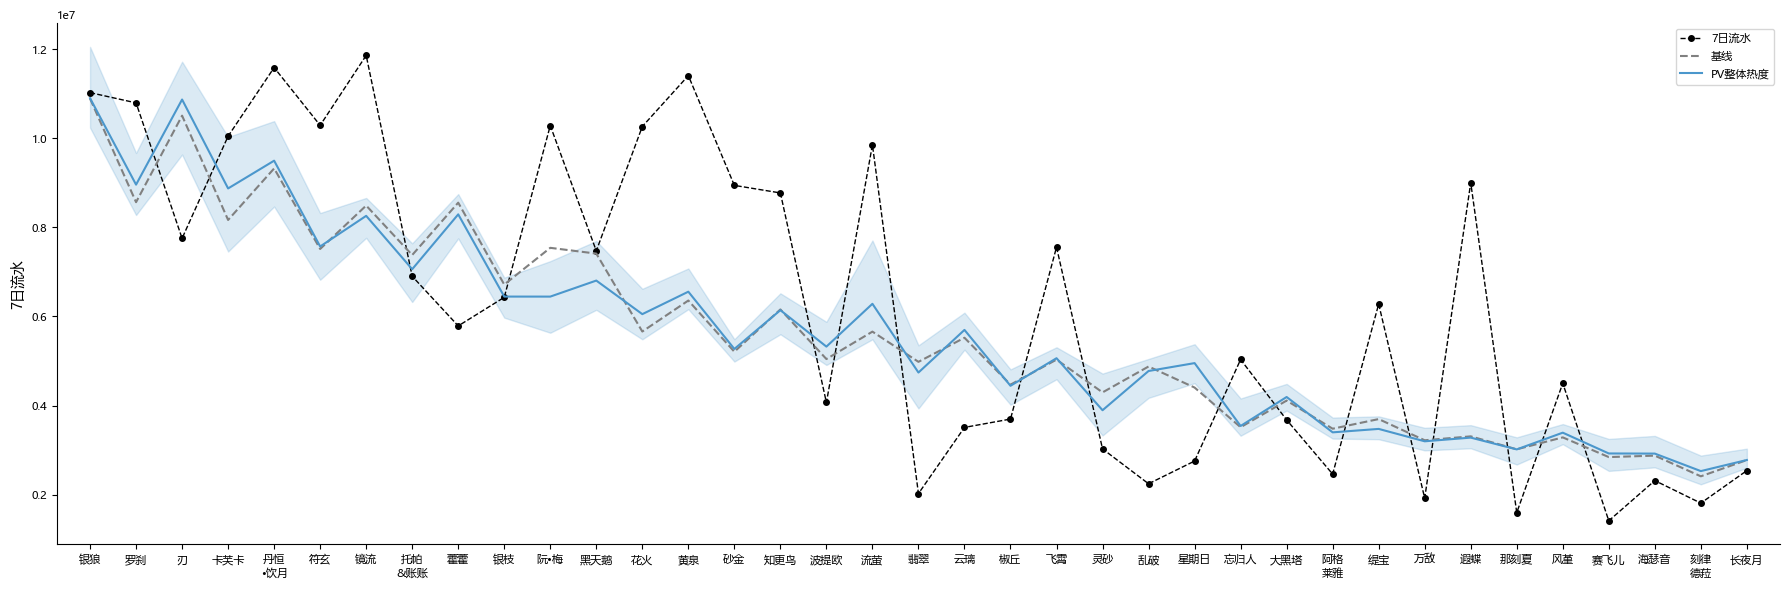


[LASSO stability] config = 'controls_only', K = 2
  总特征数：3
  总 splits 数（n_splits * n_repeats）：50
  至少一次非零的特征数：3 (100.0% of all features)
--------------------------------------------------------------------------------
  解释：
    - nz_prop：该特征在多少比例的 CV 模型中被选中（|coef| > tol）。
    - sign_stab：在被选中时，系数为正的比例；接近 1 表示稳定正效应，接近 0 表示稳定负效应。
    - nz_median：只在非零时的系数中位数，代表典型效应大小。
    - mean_all：包含零时的平均系数，体现整体 shrink 后的平均影响。
--------------------------------------------------------------------------------
  下表按 nz_prop 从高到低排序，只展示前 3 个特征：
rank  feature                                             nz_prop  sign_stab    nz_median    mean_all
   1  time_num                                            100.00%       0.00      -0.6068     -0.6105
   2  pool_index                                          100.00%       0.00      -0.1237     -0.1198
   3  gender_男                                             28.00%       0.00      -0.0350     -0.0092

[MAE summary] config = 'controls_only', K = 2, y_mode = 'log'
 

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Microsoft YaHei", "Arial", "DejaVu Sans", "Liberation Sans"],
    "axes.labelsize": 10,
    "axes.titlesize": 11,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "legend.fontsize": 8,
    'axes.grid': False,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.xmargin': 0.02,
})

colors = [
    "#249cc5", "#4b97cc", "#6d92ce", "#8b8bc9", "#a484bf", "#b77eb0", "#c57a9e",
    "#cb788b", "#cc7a79", "#c77e69", "#bd845c", "#af8a54", "#9f9152", "#8b9657",
    "#769b62", "#609e71", "#46a083", "#27a196", "#00a1a9", "#009fb9"
]
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=[colors[(1+7*i) % 20] for i in range(20)])


def find_any_key_for_config(best_artifacts_by_model, config_name: str):
    """从 artifacts 中找到某个 config 对应的一个 K（取最小的 K）。"""
    ks = sorted({k for (k, c) in best_artifacts_by_model.keys() if c == config_name})
    if not ks:
        raise KeyError(f"No artifacts found for config='{config_name}'.")
    return ks[0], config_name


def _oof_mean_ci_raw_for_chars(
    features_by_K: dict,
    artifacts: dict,
    K: int,
    config_name: str,
    target_chars: list[str],
):
    """
    给定一组 target_chars，返回该 config 在这些角色上的
    预测均值和 最大最小值（用 expm1 从 log 尺度回到原始尺度）。
    """
    art = artifacts[(K, config_name)]
    oof_list = art["oof_preds_by_repeat"]  # list of (N,)

    arr_log = np.vstack(oof_list).astype(float)
    arr_raw = np.expm1(arr_log)  # log -> raw

    df_info = features_by_K[K]["df_info"].copy()
    model_chars = df_info["character"].astype(str).tolist()
    char_to_idx = {c: i for i, c in enumerate(model_chars)}

    R, _ = arr_raw.shape
    series_raw = np.full((R, len(target_chars)), np.nan, dtype=float)
    missing = []

    for j, c in enumerate(target_chars):
        mi = char_to_idx.get(c, None)
        if mi is not None:
            series_raw[:, j] = arr_raw[:, mi]
        else:
            missing.append(c)

    if missing:
        print(
            f"[warn] config '{config_name}' is missing {len(missing)} "
            f"characters from the supposed common set; these are left as NaN."
        )

    mean = np.nanmean(series_raw, axis=0)
    lo = np.nanmin(series_raw, axis=0)
    hi = np.nanmax(series_raw, axis=0)

    return mean, lo, hi


def _break_text(text: str) -> str:
    """美化 x 轴角色名字的换行。"""
    if '·' in text:
        return text.replace('·', '\n·')
    if '&' in text:
        return text.replace('&', '\n&')
    if len(text) > 3:
        mid = len(text) // 2
        return text[:mid] + '\n' + text[mid:]
    return text


def plot_oof_time_series_for_configs(
    features_by_K: dict,
    best_artifacts_by_model: dict,
    config_names: list[str],
    Ks: list[int],
    display_names: list[str],
    line_colors: list[str],
    linestyles: list[str],
    ci_config_indices: set[int] | None = None,
    ci_csv_path: str = "data/character_info.csv",
    ylabel: str = "7日流水",
):
    """
    只绘制：真值 + 所有 config 共同覆盖到的角色上的模型预测。

    参数
    ----
    features_by_K, best_artifacts_by_model : 上游建模代码的输出
    config_names : 要绘图的配置名（与建模时的 config_name 一致）
    display_names : 图例中的中文名称
    line_colors : 每条线的颜色
    linestyles : 每条线的线型
    ci_config_indices : 需要绘制 95% CI 的 config 在列表中的下标集合，比如 {1}
    ci_csv_path : 角色真值与起始时间的 csv 路径
    """
    if ci_config_indices is None:
        ci_config_indices = set()

    if not (
        len(config_names) == len(display_names) == len(line_colors) == len(linestyles)
    ):
        raise ValueError("config_names / display_names / line_colors / linestyles 长度必须一致。")

    # 1) 读取真值与按时间排序
    ci = pd.read_csv(ci_csv_path)
    ci = ci[["character", "start_date", "7day_revenue"]].copy()
    ci["start_date"] = pd.to_datetime(ci["start_date"], errors="coerce")

    ci_sorted = ci.sort_values("start_date", kind="mergesort").reset_index(drop=True)
    order_chars_full = ci_sorted["character"].astype(str).tolist()
    y_true_full = ci_sorted["7day_revenue"].astype(float).to_numpy()
    full_set = set(order_chars_full)

    # 2) 每个 config 对应的 K 以及它实际覆盖到的角色集合
    config_to_K = {}
    config_to_chars = {}

    for i, cfg in enumerate(config_names):
        config_to_K[cfg] = Ks[i]

        df_info_cfg = features_by_K[config_to_K[cfg]]["df_info"]
        chars_cfg = set(df_info_cfg["character"].astype(str).tolist())
        config_to_chars[cfg] = chars_cfg

        missing_cfg = full_set - chars_cfg
        if missing_cfg:
            print(
                f"[warn] config '{cfg}' missing {len(missing_cfg)} characters "
                f"relative to ground truth; they cannot be used in the common subset."
            )

    # 3) 所有 config 的角色交集
    common_set = full_set
    for cfg in config_names:
        common_set = common_set & config_to_chars[cfg]

    if not common_set:
        raise ValueError("没有任何角色同时出现在所有模型设置中，无法绘图。")

    dropped_global = full_set - common_set
    order_chars_plot = [c for c in order_chars_full if c in common_set]
    mask_plot = np.array([c in common_set for c in order_chars_full], dtype=bool)
    y_true_plot = y_true_full[mask_plot]

    if dropped_global:
        print(
            f"[warn] plotting only {len(order_chars_plot)} characters shared by all configs; "
            f"dropped {len(dropped_global)} characters that are not present in at least one config."
        )

    # 4) 开始绘图（只用交集后的角色）
    x = np.arange(len(order_chars_plot))
    plt.figure(figsize=(18, 6))

    # 真值线
    plt.plot(
        x,
        y_true_plot,
        label="7日流水",
        color="black",
        linewidth=1.0,
        linestyle="--",
        marker="o",
        markersize=4,
    )

    # 各 config 预测
    for i, cfg in enumerate(config_names):
        K_cfg = config_to_K[cfg]
        mean_pred, lo_pred, hi_pred = _oof_mean_ci_raw_for_chars(
            features_by_K=features_by_K,
            artifacts=best_artifacts_by_model,
            K=K_cfg,
            config_name=cfg,
            target_chars=order_chars_plot,
        )

        plt.plot(
            x,
            mean_pred,
            label=display_names[i],
            color=line_colors[i],
            linestyle=linestyles[i],
            linewidth=1.5,
        )

        if i in ci_config_indices:
            plt.fill_between(
                x,
                lo_pred,
                hi_pred,
                color=line_colors[i],
                alpha=0.2,
            )

    # x 轴角色名字（交集后）
    formatted_chars = [_break_text(c) for c in order_chars_plot]
    plt.xticks(x, formatted_chars)
    plt.ylabel(ylabel)
    plt.legend()
    plt.tight_layout()
    plt.show()

import numpy as np
from scipy.stats import ttest_rel  # 需要安装 scipy

import numpy as np
from scipy.stats import ttest_rel  # 需要 scipy

def analyze_lasso_stability_for_configs(
    features_by_K: dict,
    best_artifacts_by_model: dict,
    config_names: list[str],
    Ks: list[int],
    top_n: int = 30,
    nonzero_tol: float = 1e-6,
    y_mode: str = "log",  # 需要和 run_model_selection_grid 时的 y_mode 一致
):
    """
    (同原注释，略)
    """
    if len(config_names) != len(Ks):
        raise ValueError("config_names 和 Ks 长度必须一致。")

    # 存每个模型的 per-instance 误差向量，供事后做配对检验
    errors_by_model = {}
    mae_by_model = {}

    # NEW: 存每个模型的 per-feature 稳定性表（topic 分析会用）
    stability_by_model = {}

    for cfg, K in zip(config_names, Ks):
        key = (K, cfg)
        if key not in best_artifacts_by_model:
            print(f"[warn] (K={K}, config='{cfg}') 不在 best_artifacts_by_model 中，跳过。")
            continue

        art = best_artifacts_by_model[key]
        feature_names = np.asarray(art["feature_names"], dtype=object)
        split_coefs_list = art["split_coefs"]
        oof_preds_by_repeat = art["oof_preds_by_repeat"]

        if len(split_coefs_list) == 0:
            print(f"[warn] (K={K}, config='{cfg}') split_coefs 为空，跳过。")
            continue

        # =========================
        # 1) 系数稳定性分析
        # =========================
        coef_mat = np.vstack(split_coefs_list).astype(float)  # (S, p)
        S, p = coef_mat.shape

        nz_mask = np.abs(coef_mat) > nonzero_tol
        nz_counts = nz_mask.sum(axis=0)
        nz_prop = nz_counts / float(S)

        sign_pos_counts = ((coef_mat > nonzero_tol) & nz_mask).sum(axis=0)
        sign_stab = np.full(p, np.nan, dtype=float)
        valid = nz_counts > 0
        sign_stab[valid] = sign_pos_counts[valid] / nz_counts[valid]

        nz_median = np.full(p, np.nan, dtype=float)
        nz_median_abs = np.full(p, np.nan, dtype=float)  # NEW
        for j in range(p):
            vals = coef_mat[nz_mask[:, j], j]
            if vals.size > 0:
                nz_median[j] = float(np.median(vals))
                nz_median_abs[j] = float(np.median(np.abs(vals)))

        mean_all = coef_mat.mean(axis=0)

        # NEW: 保存 per-feature 稳定性结果（topic 分析用它，不再重算）
        stability_df = pd.DataFrame({
            "feature": feature_names.astype(str),
            "nz_prop": nz_prop,
            "sign_stab": sign_stab,
            "nz_median": nz_median,
            "nz_median_abs": nz_median_abs,
            "mean_all": mean_all,
        })
        stability_by_model[key] = stability_df

        n_used = int((nz_prop > 0).sum())
        print("\n" + "=" * 80)
        print(f"[LASSO stability] config = '{cfg}', K = {K}")
        print(f"  总特征数：{p}")
        print(f"  总 splits 数（n_splits * n_repeats）：{S}")
        print(f"  至少一次非零的特征数：{n_used} ({n_used / p:.1%} of all features)")
        print("-" * 80)
        print("  解释：")
        print("    - nz_prop：该特征在多少比例的 CV 模型中被选中（|coef| > tol）。")
        print("    - sign_stab：在被选中时，系数为正的比例；接近 1 表示稳定正效应，接近 0 表示稳定负效应。")
        print("    - nz_median：只在非零时的系数中位数，代表典型效应大小。")
        print("    - mean_all：包含零时的平均系数，体现整体 shrink 后的平均影响。")
        print("-" * 80)
        print("  下表按 nz_prop 从高到低排序，只展示前 "
              f"{min(top_n, p)} 个特征：")
        print(f"{'rank':>4}  {'feature':<50}  {'nz_prop':>7}  "
              f"{'sign_stab':>9}  {'nz_median':>11}  {'mean_all':>10}")

        sort_idx = np.lexsort((
            np.abs(nz_median),  # 次要键
            nz_prop,            # 主要键
        ))
        order = sort_idx[::-1]

        for rank, j in enumerate(order[:top_n], start=1):
            fname = str(feature_names[j])
            print(f"{rank:>4}  {fname:<50}  {nz_prop[j]:7.2%}  "
                  f"{sign_stab[j]:9.2f}  {nz_median[j]:11.4f}  {mean_all[j]:10.4f}")

        print("=" * 80 + "\n")

        # =========================
        # 2) per-instance 误差 & MAE
        # =========================
        pack = features_by_K[K]
        if y_mode == "raw":
            y_true = pack["y_raw"].values.astype(float)
        else:
            y_true = pack["y_log"].values.astype(float)

        preds_mat = np.vstack(oof_preds_by_repeat).astype(float)  # (R, N)
        y_pred_mean = np.nanmean(preds_mat, axis=0)               # (N,)

        if y_pred_mean.shape[0] != y_true.shape[0]:
            raise ValueError(
                f"(K={K}, config='{cfg}') OOF 预测长度 {y_pred_mean.shape[0]} "
                f"与 y_true 长度 {y_true.shape[0]} 不一致。"
            )

        errors = np.abs(y_true - y_pred_mean)
        mae = errors.mean()

        errors_by_model[key] = errors
        mae_by_model[key] = mae

        print(f"[MAE summary] config = '{cfg}', K = {K}, y_mode = '{y_mode}'")
        print(f"  per-instance MAE: mean = {mae:.4f}")
        print("-" * 80)

    # =========================
    # 3) 两个模型之间的配对 t 检验（per-instance MAE）
    # =========================
    if len(config_names) == 2:
        key1 = (Ks[0], config_names[0])
        key2 = (Ks[1], config_names[1])

        if (key1 in errors_by_model) and (key2 in errors_by_model):
            err1 = errors_by_model[key1]
            err2 = errors_by_model[key2]

            if err1.shape != err2.shape:
                print("[warn] 两个模型的误差向量长度不一致，无法做配对 t 检验。")
            else:
                t_stat, p_val = ttest_rel(err1, err2)
                mae1 = mae_by_model[key1]
                mae2 = mae_by_model[key2]
                diff_mean = float((err1 - err2).mean())

                print("\n" + "#" * 80)
                print("[paired t-test on per-instance MAE]")
                print(f"  Model 1: config = '{config_names[0]}', K = {Ks[0]}")
                print(f"  Model 2: config = '{config_names[1]}', K = {Ks[1]}")
                print(f"  mean(MAE_1) = {mae1:.4f}, mean(MAE_2) = {mae2:.4f}")
                print(f"  mean(|e_1| - |e_2|) = {diff_mean:.4f}")
                print(f"  t({err1.size - 1}) = {t_stat:.4f}, p = {p_val:.4g}")
                print(f"Cohen's d = {diff_mean / np.std(err1 - err2, ddof=1):.4f}")
                print("  这里的“样本单位”是单个角色/观测点的绝对误差，")
                print("  配对 t 检验的零假设为：两模型在该数据集中的每个观测点的期望绝对误差相同。")
                print("#" * 80 + "\n")
        else:
            print("[info] 至少有一个模型没有成功计算 per-instance 误差，跳过配对 t 检验。")
    else:
        print("[info] config_names 数量 != 2，不做 MAE 的配对检验。")

    # NEW: 返回给 topic 分析用
    return {
        "stability_by_model": stability_by_model,
        "errors_by_model": errors_by_model,
        "mae_by_model": mae_by_model,
    }
# ============================
# 示例：画你的两个 baseline
# ============================
baseline_configs = [
    "controls_only",
    "controls+unweighted_PV_overall_heat",
]
base_Ks = [
    2,
    2
]
baseline_names = [
    "基线",
    "PV整体热度",
]
baseline_colors = [
    "gray",
    "#4b97cc",
]
baseline_linestyles = [
    "--",
    "-",
]


plot_oof_time_series_for_configs(
    features_by_K=features_by_K,
    best_artifacts_by_model=best_artifacts_by_model,
    config_names=baseline_configs,
    Ks=base_Ks,
    display_names=baseline_names,
    line_colors=baseline_colors,
    linestyles=baseline_linestyles,
    ci_config_indices={1},  # 只给第二条线画 95% CI（可按需调整）
    ci_csv_path="data/character_info.csv",
)

stability_df = analyze_lasso_stability_for_configs(
    features_by_K=features_by_K, 
    best_artifacts_by_model=best_artifacts_by_model,
    config_names=baseline_configs,
    Ks=base_Ks,
    top_n=30,             # 想看多少个特征
    nonzero_tol=1e-6,     # 非零阈值，可以按需要调整
)


In [41]:
def make_config_selectors():
    """
    新版（无加权）：
      - 不考虑 proportion
      - 只比较 unweighted 的 overall / topics / PV-only
    """

    def excl_prop(cols):
        return filter_by_excluding_keyword(cols, ["proportion"])

    def unweighted_topics(cols):
        cols = excl_prop(cols)
        # 仅保留 *_topic*_comment_count
        return filter_by_keyword(cols, ["comment_count"])

    def unweighted_overall(cols):
        cols = excl_prop(cols)
        # 仅保留 *_total_comments（排除 weighted_*）
        base = filter_by_keyword(cols, ["total_comments"])
        return [c for c in base if "weighted_total_comments" not in c]

    def PV_only(cols):
        cols = excl_prop(cols)
        return filter_by_keyword(cols, ["PV"])

    selectors = {
        "controls_only": lambda cols: [],

        "controls+unweighted_overall_heat": lambda cols:
            unweighted_overall(cols),

        "controls+unweighted_topics_only": lambda cols:
            unweighted_topics(cols),

    }

    return selectors
if __name__ == "__main__":
    df_available, embeddings_available, allowed_chars = restrict_comments_require_all_video_types(
        df_available=df_available,
        embeddings_available=embeddings_available,
        banner_csv_path="data/bilibili_video_with_time_to_banner.csv",
    )
    features_by_K_new = build_feature_cache_for_Ks(
        embeddings=embeddings_available,
        df_filtered=df_available,
        K_list=K_list,
        character_info_csv="data/character_info.csv",
        include_proportions=False,
        banner_csv_path="data/bilibili_video_with_time_to_banner.csv",
        embeddings_for_clustering=embeddings_available,
        character_filter=allowed_chars,   
    )
    # configs
    config_selectors = make_config_selectors()

    # alpha 网格
    # alpha_grid = np.logspace(-2, -0.5, 10)
    alpha_grid = [0.15]

    # 运行模型比较
    model_selection_df, best_artifacts_by_model = run_model_selection_grid(
        features_by_K=features_by_K_new,
        config_selectors=config_selectors,
        alpha_grid=alpha_grid,
        n_splits=5,
        n_repeats=10,
        random_state=42,
        n_jobs=-1,
        save_path="results/model_selection_baseline_allvideos.csv",
    )

    print(model_selection_df.head().to_string(index=False))

[restrict_comments_require_all_video_types] 角色总数=37, 满足条件角色数=22；裁剪后评论数=505249 / 709969

[run_model_selection_grid] ===== 开始模型比较 =====
[run_model_selection_grid] alpha_grid: min=0.15, max=0.15, len=1
[run_model_selection_grid] n_splits=5, n_repeats=10, total_splits=50, random_state=42, n_jobs=-1

[run_model_selection_grid] ===== 结束模型比较，结果已保存到: results/model_selection_baseline_allvideos.csv =====
 K                      config_name  best_alpha  n_features_total  n_topic_features  cv_mae_mean  cv_mae_std  cv_rmse_mean  cv_rmse_std  cv_r2_mean  cv_r2_std
41  controls+unweighted_topics_only        0.15               129               123     0.266348    0.033430      0.338517     0.042660    0.644000   0.085910
31  controls+unweighted_topics_only        0.15                99                93     0.272138    0.027914      0.335754     0.032082    0.651885   0.065355
11  controls+unweighted_topics_only        0.15                39                33     0.279983    0.012791      0.338541   

[warn] config 'controls_only' missing 15 characters relative to ground truth; they cannot be used in the common subset.
[warn] config 'controls+unweighted_overall_heat' missing 15 characters relative to ground truth; they cannot be used in the common subset.
[warn] plotting only 22 characters shared by all configs; dropped 15 characters that are not present in at least one config.


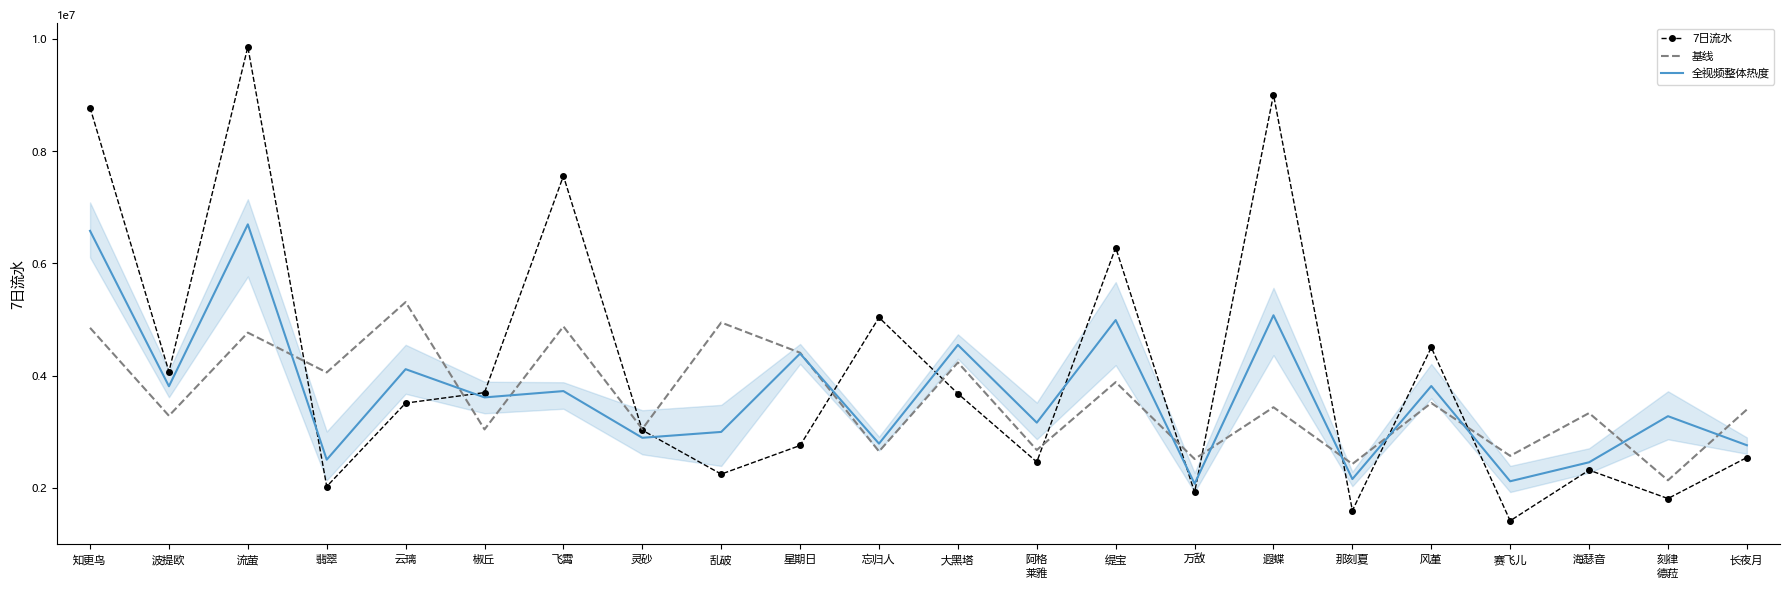


[LASSO stability] config = 'controls_only', K = 2
  总特征数：3
  总 splits 数（n_splits * n_repeats）：50
  至少一次非零的特征数：3 (100.0% of all features)
--------------------------------------------------------------------------------
  解释：
    - nz_prop：该特征在多少比例的 CV 模型中被选中（|coef| > tol）。
    - sign_stab：在被选中时，系数为正的比例；接近 1 表示稳定正效应，接近 0 表示稳定负效应。
    - nz_median：只在非零时的系数中位数，代表典型效应大小。
    - mean_all：包含零时的平均系数，体现整体 shrink 后的平均影响。
--------------------------------------------------------------------------------
  下表按 nz_prop 从高到低排序，只展示前 3 个特征：
rank  feature                                             nz_prop  sign_stab    nz_median    mean_all
   1  pool_index                                          100.00%       0.00      -0.3602     -0.3572
   2  time_num                                            100.00%       0.00      -0.3042     -0.3106
   3  gender_男                                             62.00%       0.00      -0.0557     -0.0396

[MAE summary] config = 'controls_only', K = 2, y_mode = 'log'
 

In [29]:
baseline_configs = [
    "controls_only",
    "controls+unweighted_overall_heat",
]
base_Ks = [
    2,
    2
]
baseline_names = [
    "基线",
    "全视频整体热度",
]
baseline_colors = [
    "gray",
    "#4b97cc",
]
baseline_linestyles = [
    "--",
    "-",
]


plot_oof_time_series_for_configs(
    features_by_K=features_by_K_new,
    best_artifacts_by_model=best_artifacts_by_model,
    config_names=baseline_configs,
    Ks=base_Ks,
    display_names=baseline_names,
    line_colors=baseline_colors,
    linestyles=baseline_linestyles,
    ci_config_indices={1},  # 只给第二条线画 95% CI（可按需调整）
    ci_csv_path="data/character_info.csv",
)

stability_df = analyze_lasso_stability_for_configs(
    features_by_K=features_by_K_new, 
    best_artifacts_by_model=best_artifacts_by_model,
    config_names=baseline_configs,
    Ks=base_Ks,
    top_n=30,             # 想看多少个特征
    nonzero_tol=1e-6,     # 非零阈值，可以按需要调整
)

[warn] config 'controls+unweighted_overall_heat' missing 15 characters relative to ground truth; they cannot be used in the common subset.
[warn] config 'controls+unweighted_topics_only' missing 15 characters relative to ground truth; they cannot be used in the common subset.
[warn] plotting only 22 characters shared by all configs; dropped 15 characters that are not present in at least one config.


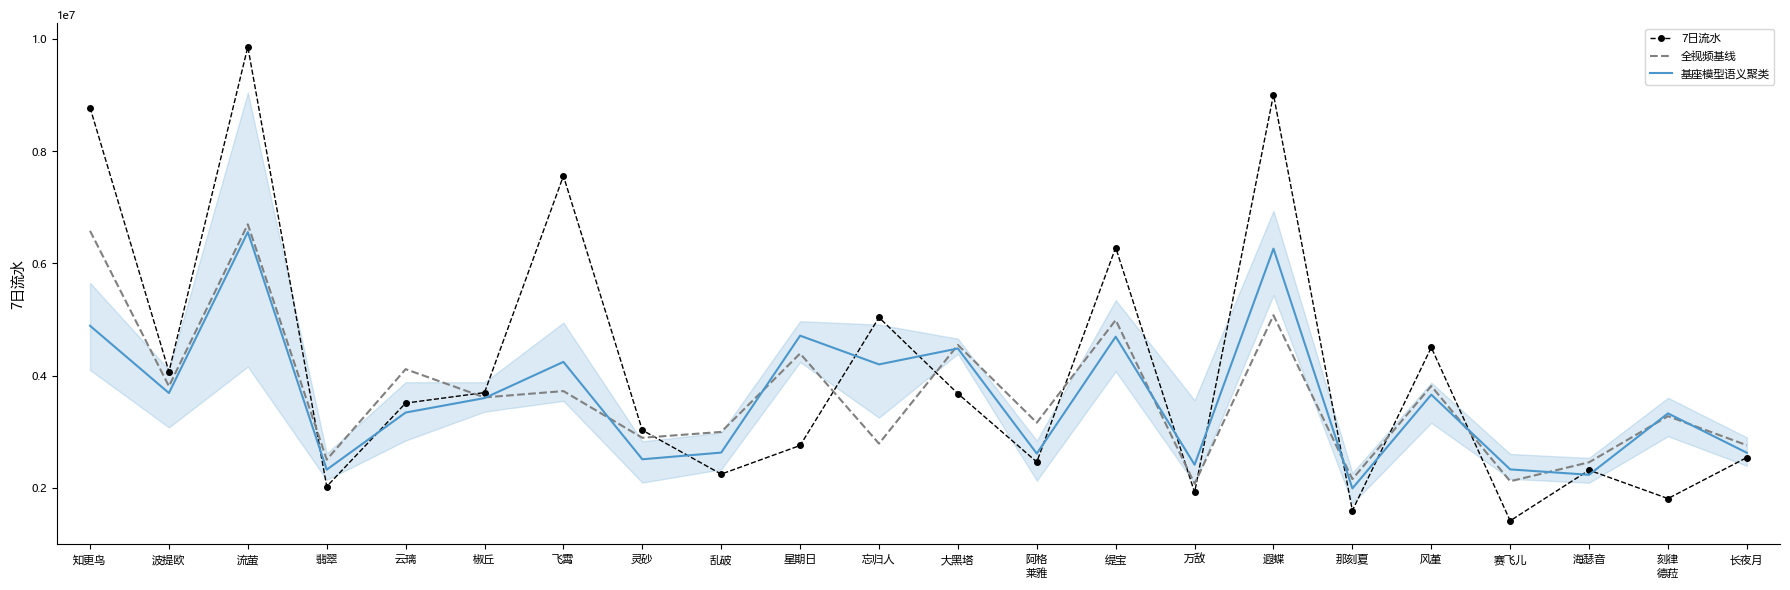


[LASSO stability] config = 'controls+unweighted_overall_heat', K = 2
  总特征数：9
  总 splits 数（n_splits * n_repeats）：50
  至少一次非零的特征数：6 (66.7% of all features)
--------------------------------------------------------------------------------
  解释：
    - nz_prop：该特征在多少比例的 CV 模型中被选中（|coef| > tol）。
    - sign_stab：在被选中时，系数为正的比例；接近 1 表示稳定正效应，接近 0 表示稳定负效应。
    - nz_median：只在非零时的系数中位数，代表典型效应大小。
    - mean_all：包含零时的平均系数，体现整体 shrink 后的平均影响。
--------------------------------------------------------------------------------
  下表按 nz_prop 从高到低排序，只展示前 9 个特征：
rank  feature                                             nz_prop  sign_stab    nz_median    mean_all
   1  综合_total_comments                                   100.00%       1.00       0.5051      0.4929
   2  time_num                                            100.00%       0.00      -0.4909     -0.4945
   3  pool_index                                           94.00%       0.00      -0.1443     -0.1308
   4  gender_男                                

In [30]:
baseline_configs = [
    "controls+unweighted_overall_heat",
    "controls+unweighted_topics_only"
]
base_Ks = [
    2,
    41
]
baseline_names = [
    "全视频基线",
    "基座模型语义聚类",
]
baseline_colors = [
    "gray",
    "#4b97cc",
]
baseline_linestyles = [
    "--",
    "-",
]


plot_oof_time_series_for_configs(
    features_by_K=features_by_K_new,
    best_artifacts_by_model=best_artifacts_by_model,
    config_names=baseline_configs,
    Ks=base_Ks,
    display_names=baseline_names,
    line_colors=baseline_colors,
    linestyles=baseline_linestyles,
    ci_config_indices={1},  # 只给第二条线画 95% CI（可按需调整）
    ci_csv_path="data/character_info.csv",
)

stability_df = analyze_lasso_stability_for_configs(
    features_by_K=features_by_K_new, 
    best_artifacts_by_model=best_artifacts_by_model,
    config_names=baseline_configs,
    Ks=base_Ks,
    top_n=30,             # 想看多少个特征
    nonzero_tol=1e-6,     # 非零阈值，可以按需要调整
)

In [ ]:
import os
import numpy as np
import pandas as pd
from typing import Literal, Optional
from joblib import Parallel, delayed
import faiss


# =====================================================
# 0. 元信息 & 后处理：两种 permutation 共用
# =====================================================

def prepare_meta(
    character_info_csv: str,
    banner_csv_path: str,
):
    """
    构造角色元信息 + availability 相关内容。
    返回一个 meta dict，供后续特征构造使用。
    """
    ci = pd.read_csv(character_info_csv)
    ci_base = ci[["character", "gender", "pool_index", "start_date", "7day_revenue"]].copy()

    date_time = pd.to_datetime(ci_base["start_date"]).astype("int64")
    ci_base["time_num"] = date_time - date_time.min()

    gender_dum = pd.get_dummies(ci_base["gender"], prefix="gender", drop_first=True)

    avail_wide, video_types, indicator_cols, indicator_col_by_vt = _load_video_availability_wide(
        banner_csv_path
    )

    char_meta = pd.concat(
        [
            ci_base[["character", "pool_index", "time_num", "start_date", "7day_revenue"]],
            gender_dum,
        ],
        axis=1,
    )

    char_meta = pd.merge(char_meta, avail_wide, on="character", how="left")
    for col in indicator_cols:
        if col not in char_meta.columns:
            char_meta[col] = 0
    char_meta[indicator_cols] = char_meta[indicator_cols].astype(int)

    base_controls = ["pool_index", "time_num"] + list(gender_dum.columns)

    meta = {
        "char_meta": char_meta,
        "video_types": video_types,
        "indicator_cols": indicator_cols,
        "indicator_col_by_vt": indicator_col_by_vt,
        "base_controls": base_controls,
    }
    return meta


def postprocess_wide_features(
    wide_features_df: pd.DataFrame,
    meta: dict,
):
    """
    从 per-K 的 wide_features_df + meta，构造与真实分析同构的 pack：
      {"X", "y_log", "y_raw", "df_info", "control_vars", "topic_cols", ...}
    """
    char_meta = meta["char_meta"]
    video_types = meta["video_types"]
    indicator_cols = meta["indicator_cols"]
    indicator_col_by_vt = meta["indicator_col_by_vt"]
    base_controls = meta["base_controls"]
    chars_in_wide = set(wide_features_df["character"].astype(str))
    char_meta_together = char_meta[
        char_meta["character"].astype(str).isin(chars_in_wide)
    ].copy()

    dfm = pd.merge(wide_features_df, char_meta_together, on="character", how="right")

    meta_cols = ["character", "start_date", "7day_revenue"] + base_controls + indicator_cols
    topic_cols = [c for c in dfm.columns if c not in meta_cols]

    # 注入结构性缺失：对不可用的 video_type 列置 NaN
    for vt in video_types:
        ind = indicator_col_by_vt.get(vt, None)
        if ind is None or ind not in dfm.columns:
            continue
        vt_cols = [c for c in topic_cols if c.startswith(f"{vt}_")]
        if vt_cols:
            dfm.loc[dfm[ind] == 0, vt_cols] = np.nan

    if topic_cols:
        dfm[topic_cols] = np.log1p(dfm[topic_cols])

    X = pd.concat(
        [
            dfm[topic_cols],
            dfm[base_controls],
            dfm[indicator_cols],
        ],
        axis=1,
    )

    y_raw = dfm["7day_revenue"].astype(float)
    y_log = np.log1p(y_raw)
    df_info = dfm[["character", "start_date"]].copy()

    pack = {
        "X": X,
        "y_log": y_log,
        "y_raw": y_raw,
        "df_info": df_info,
        "control_vars": base_controls,
        "topic_cols": topic_cols,
        "video_types": video_types,
        "availability_cols_unique": indicator_cols,
        "availability_col_by_vt": indicator_col_by_vt,
    }
    return pack


# =====================================================
# 1. Random topics（完全随机 topic 计数，不用 embeddings）
# =====================================================

def build_feature_cache_for_Ks_random_topics(
    df_filtered: pd.DataFrame,
    K_list,
    meta: dict,
    scheme: Literal["per_comment_uniform", "per_video_dirichlet"] = "per_comment_uniform",
    dirichlet_alpha: float = 1.0,
    rng: Optional[np.random.Generator] = None,
):
    """
    随机 topics：完全不使用 embeddings，直接随机生成 topic counts。
    返回的 features_by_K[K] 结构尽量与真实 build_feature_cache_for_Ks 一致。
    """
    if rng is None:
        rng = np.random.default_rng()

    df_filtered = df_filtered.copy()
    df_filtered["video_type"] = df_filtered["video_type"].astype(str)

    # 每个视频的总评论数
    group_counts = (
        df_filtered
        .groupby(["character", "video_type"], as_index=False)
        .size()
        .rename(columns={"size": "n_comments"})
    )

    # 评论级 (character, video_type)，用于 per_comment_uniform
    df_cv = df_filtered[["character", "video_type"]].copy()

    features_by_K = {}

    for K in K_list:
        K_int = int(K)

        # 1) 生成 (character, video_type, topic) 的 comment_count
        if scheme == "per_comment_uniform":
            topics = rng.integers(low=0, high=K_int, size=len(df_cv), dtype=np.int32)
            df_topics = df_cv.copy()
            df_topics["topic"] = topics

            video_topic_stats = (
                df_topics
                .groupby(["character", "video_type", "topic"], as_index=False)
                .size()
                .rename(columns={"size": "comment_count"})
            )

        elif scheme == "per_video_dirichlet":
            rows = []
            alpha_vec = np.full(K_int, float(dirichlet_alpha), dtype=float)

            for row in group_counts.itertuples(index=False):
                char = row.character
                vt = row.video_type
                n = int(row.n_comments)
                if n <= 0:
                    continue

                p = rng.dirichlet(alpha_vec)
                counts = rng.multinomial(n, p)

                for topic_id, c in enumerate(counts):
                    if c > 0:
                        rows.append((char, vt, topic_id, int(c)))

            video_topic_stats = pd.DataFrame(
                rows,
                columns=["character", "video_type", "topic", "comment_count"]
            )

        else:
            raise ValueError(f"Unknown random scheme: {scheme}")

        # 2) pivot -> wide_topic: {vt}_topic{k}_comment_count
        if len(video_topic_stats) > 0:
            wide_topic = video_topic_stats.pivot_table(
                index="character",
                columns=["video_type", "topic"],
                values="comment_count",
                fill_value=0.0,
            )
            wide_topic.columns = [
                f"{vt}_topic{t}_comment_count"
                for (vt, t) in wide_topic.columns.to_flat_index()
            ]
            wide_topic = wide_topic.reset_index()
        else:
            wide_topic = group_counts[["character"]].drop_duplicates().copy()

        # 3) overall total_comments
        overall_video_stats = group_counts.rename(columns={"n_comments": "total_comments"})
        wide_overall = overall_video_stats.pivot_table(
            index="character",
            columns="video_type",
            values="total_comments",
            fill_value=0.0,
        )
        wide_overall.columns = [
            f"{vt}_total_comments"
            for vt in wide_overall.columns.to_flat_index()
        ]
        wide_overall = wide_overall.reset_index()

        # 4) 合并 topic + overall
        wide_features_df = pd.merge(wide_topic, wide_overall, on="character", how="outer")

        # 5) 后处理 -> pack
        pack = postprocess_wide_features(wide_features_df, meta)
        features_by_K[int(K)] = pack

    return features_by_K


def run_one_random_topics_permutation(
    perm_id: int,
    df_available: pd.DataFrame,
    K_list,
    meta: dict,
    character_info_csv: str,
    banner_csv_path: str,
    alpha_grid: np.ndarray,
    config_selectors: dict,
    n_splits: int = 5,
    n_repeats: int = 1,
    cv_random_state: int = 42,
    n_jobs_cv: int = -1,
    scheme: Literal["per_comment_uniform", "per_video_dirichlet"] = "per_comment_uniform",
    dirichlet_alpha: float = 1.0,
    perm_seed: Optional[int] = None,
    save_dir: Optional[str] = "results/permutation_random_topics",
):
    """
    单次 random topics permutation：
      1) 随机生成 topic counts（完全不使用 embeddings）
      2) 构建 features_by_K_random_topics
      3) 可选：filter_features_require_all_video_types
      4) 调 run_model_selection_grid
      5) 返回全局最优 MAE 和 topic-based 最优 MAE
    """
    if perm_seed is None:
        perm_seed = np.random.randint(0, 2**31 - 1)
    rng = np.random.default_rng(perm_seed)

    features_by_K_rand = build_feature_cache_for_Ks_random_topics(
        df_filtered=df_available,
        K_list=K_list,
        meta=meta,
        scheme=scheme,
        dirichlet_alpha=dirichlet_alpha,
        rng=rng,
    )

    if save_dir is None:
        save_path = "results/model_selection_grid_perm_random_topics_tmp.csv"
    else:
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(
            save_dir,
            f"model_selection_grid_perm_random_topics_{perm_id:03d}.csv"
        )

    model_selection_df_rand, _ = run_model_selection_grid(
        features_by_K=features_by_K_rand,
        config_selectors=config_selectors,
        alpha_grid=alpha_grid,
        n_splits=n_splits,
        n_repeats=n_repeats,
        random_state=cv_random_state,
        n_jobs=n_jobs_cv,
        save_path=save_path,
    )

    best_overall_mae = float(model_selection_df_rand["cv_mae_mean"].min())

    best_topic_mae = np.nan
    topic_based_configs = [
        name for name in config_selectors.keys()
        if "topic" in name.lower()
    ]
    if topic_based_configs:
        df_topic = model_selection_df_rand[
            model_selection_df_rand["config_name"].isin(topic_based_configs)
        ]
        if not df_topic.empty:
            best_topic_mae = float(df_topic["cv_mae_mean"].min())

    return {
        "perm_id": perm_id,
        "perm_seed": perm_seed,
        "best_overall_mae": best_overall_mae,
        "best_topic_mae": best_topic_mae,
    }


def run_random_topics_permutation_test(
    df_available: pd.DataFrame,
    K_list,
    character_info_csv: str,
    banner_csv_path: str,
    alpha_grid: np.ndarray,
    config_selectors: dict,
    n_splits: int = 5,
    n_repeats: int = 1,
    cv_random_state: int = 42,
    n_jobs_cv: int = -1,
    n_permutations: int = 100,
    n_perm_jobs: int = 1,
    base_perm_seed: int = 20250101,
    scheme: Literal["per_comment_uniform", "per_video_dirichlet"] = "per_comment_uniform",
    dirichlet_alpha: float = 1.0,
    save_dir: Optional[str] = "results/permutation_random_topics",
    summary_csv: Optional[str] = "results/permutation_random_topics_summary.csv",
):
    """
    Random topics permutation test：
      - 不使用 embeddings
      - 对评论随机分到 K 个 topic
      - 与真实分析共享同一个 K grid 和 config grid
    """
    meta = prepare_meta(character_info_csv, banner_csv_path)

    perm_seeds = [base_perm_seed + i for i in range(n_permutations)]

    results = Parallel(n_jobs=n_perm_jobs)(
        delayed(run_one_random_topics_permutation)(
            perm_id=i,
            df_available=df_available,
            K_list=K_list,
            meta=meta,
            character_info_csv=character_info_csv,
            banner_csv_path=banner_csv_path,
            alpha_grid=alpha_grid,
            config_selectors=config_selectors,
            n_splits=n_splits,
            n_repeats=n_repeats,
            cv_random_state=cv_random_state,
            n_jobs_cv=n_jobs_cv,
            scheme=scheme,
            dirichlet_alpha=dirichlet_alpha,
            perm_seed=perm_seeds[i],
            save_dir=save_dir,
        )
        for i in range(n_permutations)
    )

    perm_df = pd.DataFrame(results)

    if summary_csv is not None:
        os.makedirs(os.path.dirname(summary_csv), exist_ok=True)
        perm_df.to_csv(summary_csv, index=False)

    return perm_df


# =====================================================
# 2. Random centroids（随机球面质心 + 真实 embeddings）
# =====================================================

def sample_random_centroids_for_K_list(
    K_list,
    dim: int,
    rng: np.random.Generator,
):
    """
    为每个 K 生成 K×dim 的随机质心矩阵，行向量在单位球面上。
    返回: {K: centroids_K}
    """
    centroids_by_K = {}
    for K in K_list:
        C = rng.normal(size=(int(K), dim)).astype("float32")
        faiss.normalize_L2(C)
        centroids_by_K[int(K)] = C
    return centroids_by_K


def build_feature_cache_for_Ks_random_centroids(
    embeddings: np.ndarray,
    df_filtered: pd.DataFrame,
    K_list,
    meta: dict,
    centroids_by_K: dict[int, np.ndarray],
):
    """
    与真实 build_feature_cache_for_Ks 基本相同，但不再跑 k-means；
    而是对每个 K 使用外部给定的随机质心 centroids_by_K[K]。
    """
    features_by_K = {}

    for K in K_list:
        K_int = int(K)
        centroids = centroids_by_K[K_int]

        wide_features_df, _ = generate_topic_features(
            embeddings=embeddings,
            df_labels=df_filtered,
            K=K_int,
            include_proportions=False,
            verbose=False,
            train_embeddings=None,
            centroids=centroids,
        )

        pack = postprocess_wide_features(wide_features_df, meta)
        features_by_K[K_int] = pack

    return features_by_K


def run_one_random_centroid_permutation(
    perm_id: int,
    embeddings_available: np.ndarray,
    df_available: pd.DataFrame,
    K_list,
    meta: dict,
    character_info_csv: str,
    banner_csv_path: str,
    alpha_grid: np.ndarray,
    config_selectors: dict,
    n_splits: int = 5,
    n_repeats: int = 1,
    cv_random_state: int = 42,
    n_jobs_cv: int = -1,
    perm_seed: Optional[int] = None,
    save_dir: Optional[str] = "results/permutation_random_centroids",
):
    """
    单次 random centroids permutation：
      1) 为每个 K 在单位球面上采样随机质心
      2) 用随机质心构建 features_by_K_perm
      3) 可选：filter_features_require_all_video_types
      4) 调 run_model_selection_grid
      5) 返回 best_overall_mae
    """
    if perm_seed is None:
        perm_seed = np.random.randint(0, 2**31 - 1)
    rng = np.random.default_rng(perm_seed)

    dim = embeddings_available.shape[1]
    centroids_by_K = sample_random_centroids_for_K_list(
        K_list=K_list,
        dim=dim,
        rng=rng,
    )

    features_by_K_perm = build_feature_cache_for_Ks_random_centroids(
        embeddings=embeddings_available,
        df_filtered=df_available,
        K_list=K_list,
        meta=meta,
        centroids_by_K=centroids_by_K,
    )

    if save_dir is None:
        save_path = "results/model_selection_grid_perm_random_centroids_tmp.csv"
    else:
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(
            save_dir,
            f"model_selection_grid_perm_random_centroids_{perm_id:03d}.csv"
        )

    model_selection_df_perm, _ = run_model_selection_grid(
        features_by_K=features_by_K_perm,
        config_selectors=config_selectors,
        alpha_grid=alpha_grid,
        n_splits=n_splits,
        n_repeats=n_repeats,
        random_state=cv_random_state,
        n_jobs=n_jobs_cv,
        save_path=save_path,
    )

    best_overall_mae = float(model_selection_df_perm["cv_mae_mean"].min())

    best_topic_mae = np.nan
    topic_based_configs = [
        name for name in config_selectors.keys()
        if "topic" in name.lower()
    ]
    if topic_based_configs:
        df_topic = model_selection_df_perm[
            model_selection_df_perm["config_name"].isin(topic_based_configs)
        ]
        if not df_topic.empty:
            best_topic_mae = float(df_topic["cv_mae_mean"].min())

    return {
        "perm_id": perm_id,
        "perm_seed": perm_seed,
        "best_overall_mae": best_overall_mae,
        "best_topic_mae": best_topic_mae,
    }

def run_random_centroid_permutation_test(
    embeddings_available: np.ndarray,
    df_available: pd.DataFrame,
    K_list,
    character_info_csv: str,
    banner_csv_path: str,
    alpha_grid: np.ndarray,
    config_selectors: dict,
    n_splits: int = 5,
    n_repeats: int = 1,
    cv_random_state: int = 42,
    n_jobs_cv: int = -1,
    n_permutations: int = 100,
    n_perm_jobs: int = 1,
    base_perm_seed: int = 20250101,
    save_dir: Optional[str] = "results/permutation_random_centroids",
    summary_csv: Optional[str] = "results/permutation_random_centroids_summary.csv",
):
    """
    Random centroids permutation test：
      - 使用真实 embeddings
      - 为每个 K 采样随机质心
      - 与真实分析共享同一个 K grid 和 config grid
    """
    meta = prepare_meta(character_info_csv, banner_csv_path)

    perm_seeds = [base_perm_seed + i for i in range(n_permutations)]

    results = Parallel(n_jobs=n_perm_jobs)(
        delayed(run_one_random_centroid_permutation)(
            perm_id=i,
            embeddings_available=embeddings_available,
            df_available=df_available,
            K_list=K_list,
            meta=meta,
            character_info_csv=character_info_csv,
            banner_csv_path=banner_csv_path,
            alpha_grid=alpha_grid,
            config_selectors=config_selectors,
            n_splits=n_splits,
            n_repeats=n_repeats,
            cv_random_state=cv_random_state,
            n_jobs_cv=n_jobs_cv,
            perm_seed=perm_seeds[i],
            save_dir=save_dir,
        )
        for i in range(n_permutations)
    )

    perm_df = pd.DataFrame(results)

    if summary_csv is not None:
        os.makedirs(os.path.dirname(summary_csv), exist_ok=True)
        perm_df.to_csv(summary_csv, index=False)

    return perm_df


# =====================================================
# 3. 拟合结果 + permutation 结果分析
# =====================================================

def summarize_real(real_df: pd.DataFrame):
    print("===== 真实模型：全局最优 =====")
    idx_best = real_df["cv_mae_mean"].idxmin()
    best_row = real_df.loc[idx_best]

    best_mae = float(best_row["cv_mae_mean"])
    best_rmse = float(best_row["cv_rmse_mean"])
    best_K = int(best_row["K"])
    best_config = best_row["config_name"]

    print(f"Best overall:")
    print(f"  K = {best_K}")
    print(f"  config_name = {best_config}")
    print(f"  cv_mae_mean = {best_mae:.6f}")
    print(f"  cv_rmse_mean = {best_rmse:.6f}")
    print()

    print("===== 真实模型：按 config_name 汇总 =====")
    grp = real_df.groupby("config_name", as_index=False).apply(
        lambda g: g.loc[g["cv_mae_mean"].idxmin()]
    )
    grp = grp.reset_index(drop=True)

    cols_show = [
        "config_name", "K", "cv_mae_mean", "cv_mae_std",
        "cv_rmse_mean", "cv_rmse_std", "n_features_total", "n_topic_features"
    ]
    cols_show = [c for c in cols_show if c in grp.columns]

    print(grp[cols_show].sort_values("cv_mae_mean"))
    print()

    return best_mae, best_row


def summarize_permutations(perm_df: pd.DataFrame, col: str = "best_overall_mae"):
    print(f"===== Permutation：{col} 分布 =====")
    x = perm_df[col].dropna().values
    print(f"  n_permutations = {len(x)}")
    print(f"  mean  = {x.mean():.6f}")
    print(f"  std   = {x.std(ddof=1):.6f}")
    print(f"  min   = {x.min():.6f}")
    print(f"  5%    = {np.quantile(x, 0.05):.6f}")
    print(f"  25%   = {np.quantile(x, 0.25):.6f}")
    print(f"  50%   = {np.quantile(x, 0.50):.6f}")
    print(f"  75%   = {np.quantile(x, 0.75):.6f}")
    print(f"  95%   = {np.quantile(x, 0.95):.6f}")
    print(f"  max   = {x.max():.6f}")
    print()

    return x


def compute_empirical_pvalue(real_best_mae: float, perm_best_overall: np.ndarray):
    """
    经验 p-value（单侧）：真实 best MAE 是否显著优于 baseline。
    越小 MAE 越好，因此看 perm <= real 的比例。
    """
    x = perm_best_overall
    n = len(x)
    count_better_or_equal = np.sum(x <= real_best_mae)
    p_hat = (1.0 + count_better_or_equal) / (n + 1.0)

    print("===== 经验 p-value (基于 best_overall_mae) =====")
    print(f"  real best cv_mae_mean = {real_best_mae:.6f}")
    print(f"  perm <= real 的次数 = {count_better_or_equal} / {n}")
    print(f"  经验 p-value ≈ {p_hat:.6f}")
    print()

    return p_hat


# =====================================================
# 4. 示例调用：两种 permutation + 对比真实结果
# =====================================================

# 1) random topics / random cluster
perm_results_random_topics = run_random_topics_permutation_test(
    df_available=df_available,
    K_list=K_list,
    character_info_csv="data/character_info.csv",
    banner_csv_path="data/bilibili_video_with_time_to_banner.csv",
    alpha_grid=alpha_grid,
    config_selectors=config_selectors,
    n_splits=5,
    n_repeats=10,
    cv_random_state=42,
    n_jobs_cv=-1,
    n_permutations=200,
    n_perm_jobs=1,
    base_perm_seed=20250101,
    scheme="per_video_dirichlet",
    dirichlet_alpha=1.0,
    save_dir="results/permutation_random_topics",
    summary_csv="results/permutation_random_topics_summary.csv",
)

# print(perm_results_random_topics.head())

# 2) random centroids
perm_results_random_centroids = run_random_centroid_permutation_test(
    embeddings_available=embeddings_available,
    df_available=df_available,
    K_list=K_list,
    character_info_csv="data/character_info.csv",
    banner_csv_path="data/bilibili_video_with_time_to_banner.csv",
    alpha_grid=alpha_grid,
    config_selectors=config_selectors,
    n_splits=5,
    n_repeats=10,
    cv_random_state=42,
    n_jobs_cv=-1,
    n_permutations=200,
    n_perm_jobs=1,
    base_perm_seed=20250201,
    save_dir="results/permutation_random_centroids",
    summary_csv="results/permutation_random_centroids_summary.csv",
)

# print(perm_results_random_centroids.head())

# 3) 真实结果 vs 两种 permutation
real_best_mae, real_best_row = summarize_real(model_selection_df)

perm_best_overall_topics = summarize_permutations(perm_results_random_topics, col="best_topic_mae")
p_topics = compute_empirical_pvalue(real_best_mae, perm_best_overall_topics)

perm_best_overall_centroids = summarize_permutations(perm_results_random_centroids, col="best_topic_mae")
p_centroids = compute_empirical_pvalue(real_best_mae, perm_best_overall_centroids)

print("===== Random topics permutation：按 best_topic_mae 排序，前 10 行 =====")
print(
    perm_results_random_topics.sort_values("best_topic_mae")
    .head(10)
    .reset_index(drop=True)
)

print("===== Random centroids permutation：按 best_topic_mae 排序，前 10 行 =====")
print(
    perm_results_random_centroids.sort_values("best_topic_mae")
    .head(10)
    .reset_index(drop=True)
)


===== 真实模型：全局最优 =====
Best overall:
  K = 41
  config_name = controls+unweighted_topics_only
  cv_mae_mean = 0.266348
  cv_rmse_mean = 0.338517

===== 真实模型：按 config_name 汇总 =====
                        config_name   K  cv_mae_mean  cv_mae_std  \
1   controls+unweighted_topics_only  41     0.266348    0.033430   
0  controls+unweighted_overall_heat   2     0.283343    0.014409   
2                     controls_only   2     0.422223    0.018323   

   cv_rmse_mean  cv_rmse_std  n_features_total  n_topic_features  
1      0.338517     0.042660               129               123  
0      0.348952     0.016326                 9                 3  
2      0.490099     0.021381                 3                 0  

===== Permutation：best_topic_mae 分布 =====
  n_permutations = 200
  mean  = 0.349201
  std   = 0.025923
  min   = 0.269132
  5%    = 0.304405
  25%   = 0.333959
  50%   = 0.350297
  75%   = 0.368461
  95%   = 0.387455
  max   = 0.419220

===== 经验 p-value (基于 best_overall_mae) ===

C:\Users\xiaoyi\AppData\Local\Temp\ipykernel_51844\3068617618.py:598: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grp = real_df.groupby("config_name", as_index=False).apply(


In [32]:
p_topics = compute_empirical_pvalue(0.283343, perm_best_overall_topics)
p_centroids = compute_empirical_pvalue(0.283343, perm_best_overall_centroids)

===== 经验 p-value (基于 best_overall_mae) =====
  real best cv_mae_mean = 0.283343
  perm <= real 的次数 = 3 / 200
  经验 p-value ≈ 0.019900

===== 经验 p-value (基于 best_overall_mae) =====
  real best cv_mae_mean = 0.283343
  perm <= real 的次数 = 142 / 200
  经验 p-value ≈ 0.711443



In [42]:
if __name__ == "__main__":
    features_by_K_new = build_feature_cache_for_Ks(
        embeddings=embeddings_available,
        df_filtered=df_available,
        K_list=K_list,
        character_info_csv="data/character_info.csv",
        include_proportions=False,
        banner_csv_path="data/bilibili_video_with_time_to_banner.csv",
        embeddings_for_clustering=embeddings_available,
        df_for_clustering=df_available,
        cluster_video_types=["综合"],
        character_filter=allowed_chars,
    )

    # 运行模型比较
    model_selection_df2, best_artifacts_by_model = run_model_selection_grid(
        features_by_K=features_by_K_new,
        config_selectors=config_selectors,
        alpha_grid=alpha_grid,
        n_splits=5,
        n_repeats=10,
        random_state=42,
        n_jobs=-1,
        save_path="results/model_selection_baseline_zonghecluster_allvideos.csv",
    )
    print(model_selection_df2.head().to_string(index=False))


[run_model_selection_grid] ===== 开始模型比较 =====
[run_model_selection_grid] alpha_grid: min=0.15, max=0.15, len=1
[run_model_selection_grid] n_splits=5, n_repeats=10, total_splits=50, random_state=42, n_jobs=-1

[run_model_selection_grid] ===== 结束模型比较，结果已保存到: results/model_selection_baseline_zonghecluster_allvideos.csv =====
 K                      config_name  best_alpha  n_features_total  n_topic_features  cv_mae_mean  cv_mae_std  cv_rmse_mean  cv_rmse_std  cv_r2_mean  cv_r2_std
21  controls+unweighted_topics_only        0.15                69                63     0.270705    0.016711      0.317683     0.019986    0.689788   0.038562
20  controls+unweighted_topics_only        0.15                66                60     0.278033    0.017240      0.345411     0.021256    0.633330   0.044084
 2 controls+unweighted_overall_heat        0.15                 9                 3     0.283343    0.014409      0.348952     0.016326    0.626309   0.034793
19  controls+unweighted_topics_only    

In [34]:
def compare_permutations(x,y):
    obs = np.median(y) - np.median(x)

    z = np.concatenate([x, y])
    n1 = len(x)

    rng = np.random.default_rng(0)
    B = 20000
    null = np.empty(B)

    for b in range(B):
        perm = rng.permutation(z)
        null[b] = np.median(perm[n1:]) - np.median(perm[:n1])

    p_two = (np.sum(np.abs(null) >= abs(obs)) + 1) / (B + 1)
    print("obs(median diff)=", obs, "p(two-sided)=", p_two)


compare_permutations(
    x=model_selection_df.loc[model_selection_df["config_name"].str.contains("topic"), "cv_mae_mean"].to_numpy(),
    y=model_selection_df2.loc[model_selection_df2["config_name"].str.contains("topic"), "cv_mae_mean"].to_numpy()
)

obs(median diff)= -0.016429610772890735 p(two-sided)= 0.06824658767061646


[warn] config 'controls+unweighted_overall_heat' missing 15 characters relative to ground truth; they cannot be used in the common subset.
[warn] config 'controls+unweighted_topics_only' missing 15 characters relative to ground truth; they cannot be used in the common subset.
[warn] plotting only 22 characters shared by all configs; dropped 15 characters that are not present in at least one config.


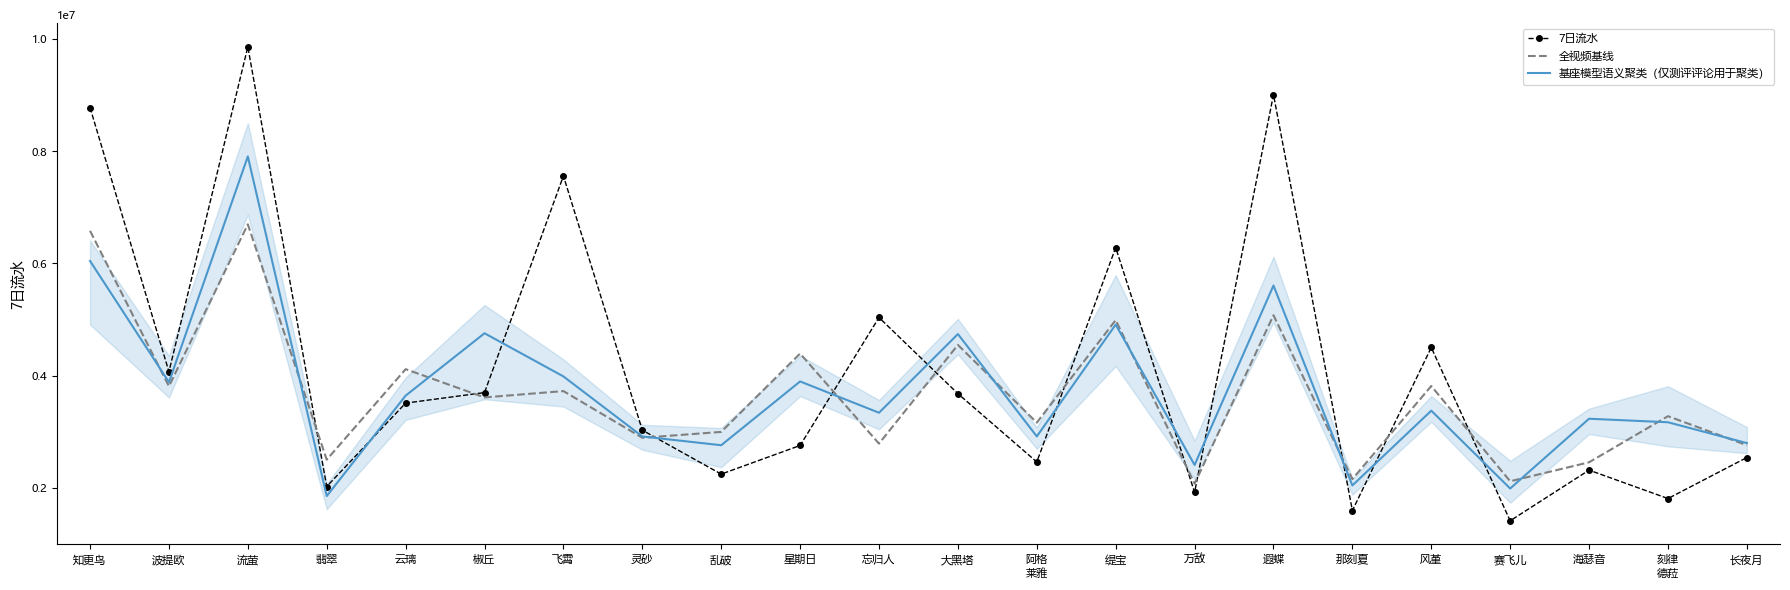


[LASSO stability] config = 'controls+unweighted_overall_heat', K = 2
  总特征数：9
  总 splits 数（n_splits * n_repeats）：50
  至少一次非零的特征数：6 (66.7% of all features)
--------------------------------------------------------------------------------
  解释：
    - nz_prop：该特征在多少比例的 CV 模型中被选中（|coef| > tol）。
    - sign_stab：在被选中时，系数为正的比例；接近 1 表示稳定正效应，接近 0 表示稳定负效应。
    - nz_median：只在非零时的系数中位数，代表典型效应大小。
    - mean_all：包含零时的平均系数，体现整体 shrink 后的平均影响。
--------------------------------------------------------------------------------
  下表按 nz_prop 从高到低排序，只展示前 9 个特征：
rank  feature                                             nz_prop  sign_stab    nz_median    mean_all
   1  综合_total_comments                                   100.00%       1.00       0.5051      0.4929
   2  time_num                                            100.00%       0.00      -0.4909     -0.4945
   3  pool_index                                           94.00%       0.00      -0.1443     -0.1308
   4  gender_男                                

C:\Users\xiaoyi\AppData\Local\Temp\ipykernel_51844\3068617618.py:598: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grp = real_df.groupby("config_name", as_index=False).apply(


In [43]:
baseline_configs = [
    "controls+unweighted_overall_heat",
    "controls+unweighted_topics_only"
]
base_Ks = [
    2,
    21
]
baseline_names = [
    "全视频基线",
    "基座模型语义聚类（仅测评评论用于聚类）",
]
baseline_colors = [
    "gray",
    "#4b97cc",
]
baseline_linestyles = [
    "--",
    "-",
]


plot_oof_time_series_for_configs(
    features_by_K=features_by_K_new,
    best_artifacts_by_model=best_artifacts_by_model,
    config_names=baseline_configs,
    Ks=base_Ks,
    display_names=baseline_names,
    line_colors=baseline_colors,
    linestyles=baseline_linestyles,
    ci_config_indices={1},  # 只给第二条线画 95% CI（可按需调整）
    ci_csv_path="data/character_info.csv",
)

stability_df = analyze_lasso_stability_for_configs(
    features_by_K=features_by_K_new, 
    best_artifacts_by_model=best_artifacts_by_model,
    config_names=baseline_configs,
    Ks=base_Ks,
    top_n=30,             # 想看多少个特征
    nonzero_tol=1e-6,     # 非零阈值，可以按需要调整
)
real_best_mae, real_best_row = summarize_real(model_selection_df2)
p_centroids = compute_empirical_pvalue(real_best_mae, perm_best_overall_centroids)

[Info] Loading output\tsdae-bert-20251207_104308\test_metrics.csv ...
[Info] Saving plot to output\tsdae-bert-20251207_104308\plots\metrics_2x2_summary.png


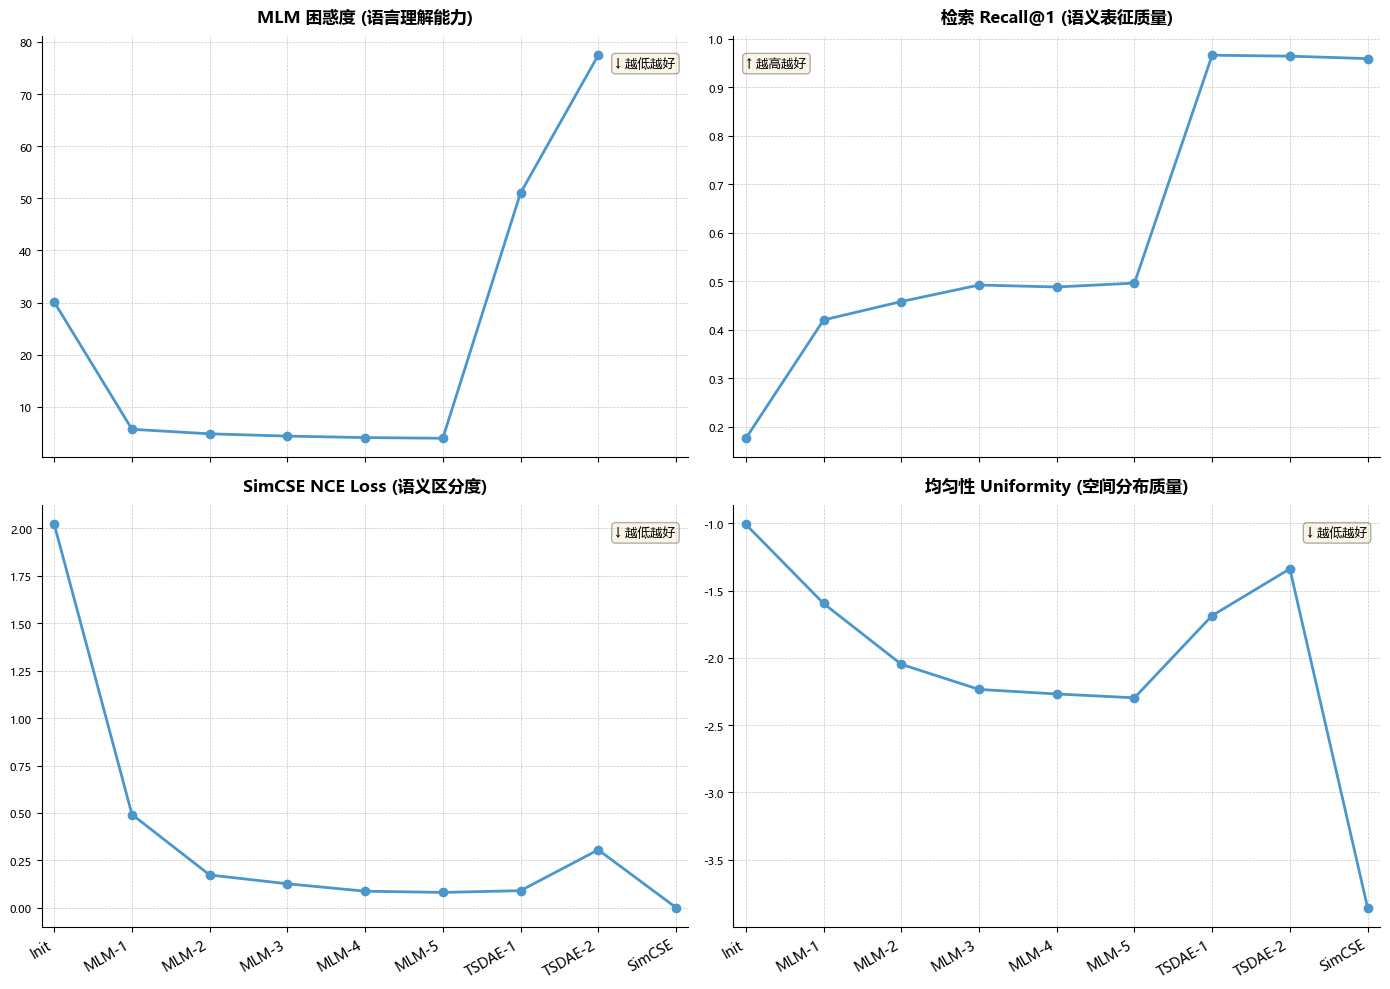

In [11]:
# -*- coding: utf-8 -*-
"""
Plot 4 key metrics in a 2x2 grid for Zhihu article.
"""

import argparse
from pathlib import Path
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# 配置字体
plt.rcParams['axes.unicode_minus'] = False 
# plt.rcParams['font.sans-serif'] = ['SimHei'] # 如需中文请取消注释

def _normalize_path(p: str) -> Path:
    p = p.strip().strip('"').strip("'")
    return Path(p)

def _clean_and_filter_df(df: pd.DataFrame) -> pd.DataFrame:
    """
    清洗数据：删除冗余行，简化 Tag
    """
    # 1. 过滤掉完全冗余的行
    drop_tags = ["After-MLM", "After-TSDAE-Phase1", "After-MNR-Baseline-ep1.0"]
    df = df[~df["tag"].isin(drop_tags)].copy()
    
    # 2. 简化 Tag 显示
    def simplify_tag(t):
        t = t.replace("Before-MLM", "Init")
        t = t.replace("After-MLM-ep", "MLM-")
        t = t.replace("After-TSDAE-Phase2-ep", "TSDAE-")
        # if "MNR-Baseline" in t: t = "MNR-Base"
        if "MNR-Precomputed" in t: t = "SimCSE"
        t = re.sub(r"\.0$", "", t)
        return t

    df["short_tag"] = df["tag"].apply(simplify_tag)
    return df

def _mask_irrelevant_data(df: pd.DataFrame, col: str) -> list:
    """
    数据遮罩逻辑
    """
    vals = df[col].astype(float).tolist()
    tags = df["tag"].tolist()
    
    new_vals = []
    for t, v in zip(tags, vals):
        is_mnr_stage = "MNR" in t
        
        # 规则 1: SimCSE 阶段 (MNR) 的 MLM PPL 飙升且无意义，掩盖掉
        # (因为 MNR 阶段只训练 Encoder，且 SimCSE 目标与 MLM 冲突，导致 PPL 爆炸)
        if col == "mlm_ppl" and is_mnr_stage:
            new_vals.append(np.nan)
        
        # 规则 2: SimCSE NCE Loss 全程保留
        # 即使在 MLM/TSDAE 阶段没训练 NCE，计算它也能作为 Baseline 展示
        else:
            new_vals.append(v)
            
    return new_vals

def plot_2x2_grid(df: pd.DataFrame, out_path: Path):
    # 配置：只画这 4 个
    # 注意：这里继续使用 mlm_ppl 而不是 loss，因为 PPL (exp(loss)) 的视觉变化更直观，
    # 代表“困惑度”的下降。如果你执意要 raw loss，可以将 'mlm_ppl' 改为 'mlm_loss'。
    metrics_config = [
        # (Column Name, Display Title, Trend Note)
        # PPL 反映的是模型对领域黑话的“熟悉程度”
        ("mlm_ppl", "MLM 困惑度 (语言理解能力)", "↓ 越低越好"),

        # Recall@1 反映的是向量能不能精准指代原义，是综合质量最好的体现
        ("emb_r1", "检索 Recall@1 (语义表征质量)", "↑ 越高越好"),

        # NCE Loss 反映的是正负例在空间中分得有多开
        ("simcse_nce", "SimCSE NCE Loss (语义区分度)", "↓ 越低越好"),

        # Uniformity 反映的是向量有没有利用好整个球面空间
        ("uniformity", "均匀性 Uniformity (空间分布质量)", "↓ 越低越好"),
    ]

    # 设置 2x2 画布
    fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)
    axes = axes.flatten()
    
    x_labels = df["short_tag"].tolist()
    x_indices = range(len(x_labels))

    for i, (col, title, note) in enumerate(metrics_config):
        if col not in df.columns:
            continue
            
        ax = axes[i]
        y_values = _mask_irrelevant_data(df, col)
        
        # 绘图
        ax.plot(x_indices, y_values, marker='o', linewidth=2, markersize=6, color="#4b97cc")
        
        # 标题与说明
        ax.set_title(title, fontsize=12, fontweight='bold', pad=10)
        
        # 右上角标注
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.3)
        ax.text(0.02 if i==1 else 0.98, 0.95, note, transform=ax.transAxes, fontsize=9,
                verticalalignment='top', horizontalalignment='left' if i==1 else 'right', bbox=props)
        
        ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    # X轴标签处理 (只在最底下一排显示)
    for ax in axes[1:]:
        ax.set_xticks(x_indices)

        ax.set_xticklabels(x_labels, rotation=30, ha='right', fontsize=10)
    
    plt.tight_layout()
    print(f"[Info] Saving plot to {out_path}")
    plt.savefig(out_path, dpi=300, bbox_inches='tight')
    plt.show()

if __name__ == "__main__":
    csv_path = Path("./output/tsdae-bert-20251207_104308/test_metrics.csv")

    print(f"[Info] Loading {csv_path} ...")
    df = pd.read_csv(csv_path)
    df = _clean_and_filter_df(df)
    
    out_dir = csv_path.parent / "plots"
    out_dir.mkdir(parents=True, exist_ok=True)
    out_file = out_dir / "metrics_2x2_summary.png"
    
    plot_2x2_grid(df, out_file)

In [36]:
if __name__ == "__main__":
    df = pd.read_pickle("comments_preprocessed.pkl")

    df = df.reset_index(drop=True).copy()
    df["__row_id__"] = np.arange(len(df), dtype=int)

    # 2) 全量评论用于聚类训练
    train_texts_all = df["评论内容"].tolist()

    # 3) 可用评论用于 topic 计数聚合
    df_available = filter_available_comments(
        df,
        banner_csv_path="data/bilibili_video_with_time_to_banner.csv",
    )

    # 4) 生成/加载“全量评论”的 embeddings（命名也改清楚）
    try:
        print("尝试加载已存在的全量embeddings...")
        embeddings_all = np.load("emb_train_all_unweighted_final.npy").astype("float32")
    except FileNotFoundError:
        print("未找到全量embeddings，开始重新计算（全量语料 + 无加权）...")
        st_model = SentenceTransformer(
            "./output/tsdae-bert-20251207_104308/final_mnr_precomputed",
            device="cuda"
        )
        embeddings_all = st_model.encode(
            train_texts_all,
            batch_size=256,
            normalize_embeddings=True,
            show_progress_bar=True
        ).astype("float32")
        np.save("emb_train_all_unweighted_final.npy", embeddings_all)

    # 5) 只保留一次归一化（若 encode 已 normalize，这里也不会出大问题）
    faiss.normalize_L2(embeddings_all)

    # 6) 从“全量 embeddings”中切出“可用评论 embeddings”
    avail_ids = df_available["__row_id__"].to_numpy(dtype=int)
    embeddings_available = embeddings_all[avail_ids]

    # 7) K 候选集合
    K_list = range(2, 51)

    # 8) 角色级特征缓存
    #    - embeddings: 用可用评论（用于 labels/聚合）
    #    - embeddings_for_clustering: 用全量评论（训练聚类）
    df_available, embeddings_available, allowed_chars = restrict_comments_require_all_video_types(
        df_available=df_available,
        embeddings_available=embeddings_available,
        banner_csv_path="data/bilibili_video_with_time_to_banner.csv",
    )
    features_by_K_new = build_feature_cache_for_Ks(
        embeddings=embeddings_available,
        df_filtered=df_available,
        K_list=K_list,
        character_info_csv="data/character_info.csv",
        include_proportions=False,
        banner_csv_path="data/bilibili_video_with_time_to_banner.csv",
        embeddings_for_clustering=embeddings_available,
        # df_for_clustering=df_available,
        # cluster_video_types=["综合"],
        character_filter=allowed_chars,
    )

    # configs
    config_selectors = make_config_selectors()

    # alpha 网格


    # 运行模型比较
    model_selection_df, best_artifacts_by_model = run_model_selection_grid(
        features_by_K=features_by_K_new,
        config_selectors=config_selectors,
        alpha_grid=alpha_grid,
        n_splits=5,
        n_repeats=10,
        random_state=42,
        n_jobs=-1,
        save_path="results/model_selection_final.csv",
    )

    print(model_selection_df.head().to_string(index=False))
            


[filter_available_comments] 原始评论数=1261033, 可用评论数=709969
尝试加载已存在的全量embeddings...
[restrict_comments_require_all_video_types] 角色总数=37, 满足条件角色数=22；裁剪后评论数=505249 / 709969

[run_model_selection_grid] ===== 开始模型比较 =====
[run_model_selection_grid] alpha_grid: min=0.15, max=0.15, len=1
[run_model_selection_grid] n_splits=5, n_repeats=10, total_splits=50, random_state=42, n_jobs=-1

[run_model_selection_grid] ===== 结束模型比较，结果已保存到: results/model_selection_final.csv =====
 K                     config_name  best_alpha  n_features_total  n_topic_features  cv_mae_mean  cv_mae_std  cv_rmse_mean  cv_rmse_std  cv_r2_mean  cv_r2_std
18 controls+unweighted_topics_only        0.15                60                54     0.207320    0.026181      0.277809     0.027175    0.761579   0.046429
16 controls+unweighted_topics_only        0.15                54                48     0.225388    0.016584      0.295240     0.024195    0.731408   0.045201
 7 controls+unweighted_topics_only        0.15               

In [37]:
features_by_K_new = build_feature_cache_for_Ks(
    embeddings=embeddings_available,
    df_filtered=df_available,
    K_list=K_list,
    character_info_csv="data/character_info.csv",
    include_proportions=False,
    banner_csv_path="data/bilibili_video_with_time_to_banner.csv",
    embeddings_for_clustering=embeddings_available,
    df_for_clustering=df_available,
    cluster_video_types=["综合"],
    character_filter=allowed_chars,
)

# configs
config_selectors = make_config_selectors()

# alpha 网格


# 运行模型比较
model_selection_df2, best_artifacts_by_model = run_model_selection_grid(
    features_by_K=features_by_K_new,
    config_selectors=config_selectors,
    alpha_grid=alpha_grid,
    n_splits=5,
    n_repeats=10,
    random_state=42,
    n_jobs=-1,
    save_path="results/model_selection_final.csv",
)

print(model_selection_df2.head().to_string(index=False))


[run_model_selection_grid] ===== 开始模型比较 =====
[run_model_selection_grid] alpha_grid: min=0.15, max=0.15, len=1
[run_model_selection_grid] n_splits=5, n_repeats=10, total_splits=50, random_state=42, n_jobs=-1

[run_model_selection_grid] ===== 结束模型比较，结果已保存到: results/model_selection_final.csv =====
 K                     config_name  best_alpha  n_features_total  n_topic_features  cv_mae_mean  cv_mae_std  cv_rmse_mean  cv_rmse_std  cv_r2_mean  cv_r2_std
37 controls+unweighted_topics_only        0.15               117               111     0.188493    0.014604      0.251876     0.018112    0.804783   0.028600
32 controls+unweighted_topics_only        0.15               102                96     0.209380    0.010647      0.257172     0.016110    0.796715   0.025924
35 controls+unweighted_topics_only        0.15               111               105     0.223826    0.022713      0.292266     0.026673    0.736411   0.047802
38 controls+unweighted_topics_only        0.15               120      

In [38]:
def compare_permutations(x,y):
    obs = np.median(y) - np.median(x)

    z = np.concatenate([x, y])
    n1 = len(x)

    rng = np.random.default_rng(0)
    B = 20000
    null = np.empty(B)

    for b in range(B):
        perm = rng.permutation(z)
        null[b] = np.median(perm[n1:]) - np.median(perm[:n1])

    p_two = (np.sum(np.abs(null) >= abs(obs)) + 1) / (B + 1)
    print("obs(median diff)=", obs, "p(two-sided)=", p_two)
compare_permutations(
    x=model_selection_df.loc[model_selection_df["config_name"].str.contains("topic"), "cv_mae_mean"].to_numpy(),
    y=model_selection_df2.loc[model_selection_df2["config_name"].str.contains("topic"), "cv_mae_mean"].to_numpy()
)

obs(median diff)= -0.03410178997785074 p(two-sided)= 0.000199990000499975


[warn] config 'controls+unweighted_overall_heat' missing 15 characters relative to ground truth; they cannot be used in the common subset.
[warn] config 'controls+unweighted_topics_only' missing 15 characters relative to ground truth; they cannot be used in the common subset.
[warn] plotting only 22 characters shared by all configs; dropped 15 characters that are not present in at least one config.


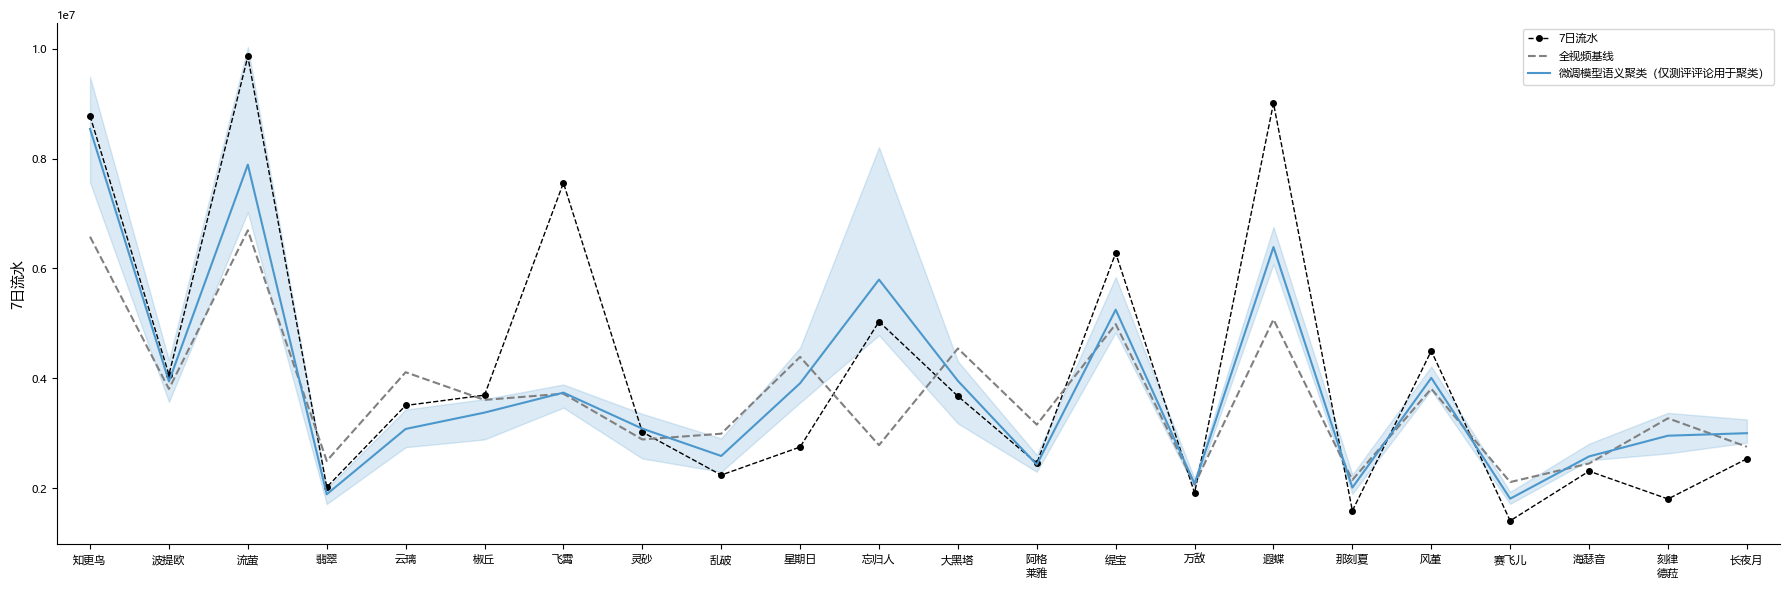


[LASSO stability] config = 'controls+unweighted_overall_heat', K = 2
  总特征数：9
  总 splits 数（n_splits * n_repeats）：50
  至少一次非零的特征数：6 (66.7% of all features)
--------------------------------------------------------------------------------
  解释：
    - nz_prop：该特征在多少比例的 CV 模型中被选中（|coef| > tol）。
    - sign_stab：在被选中时，系数为正的比例；接近 1 表示稳定正效应，接近 0 表示稳定负效应。
    - nz_median：只在非零时的系数中位数，代表典型效应大小。
    - mean_all：包含零时的平均系数，体现整体 shrink 后的平均影响。
--------------------------------------------------------------------------------
  下表按 nz_prop 从高到低排序，只展示前 9 个特征：
rank  feature                                             nz_prop  sign_stab    nz_median    mean_all
   1  综合_total_comments                                   100.00%       1.00       0.5051      0.4929
   2  time_num                                            100.00%       0.00      -0.4909     -0.4945
   3  pool_index                                           94.00%       0.00      -0.1443     -0.1308
   4  gender_男                                

In [39]:
baseline_configs = [
    "controls+unweighted_overall_heat",
    "controls+unweighted_topics_only"
]
base_Ks = [
    2,
    37
]
baseline_names = [
    "全视频基线",
    "微调模型语义聚类（仅测评评论用于聚类）",
]
baseline_colors = [
    "gray",
    "#4b97cc",
]
baseline_linestyles = [
    "--",
    "-",
]


plot_oof_time_series_for_configs(
    features_by_K=features_by_K_new,
    best_artifacts_by_model=best_artifacts_by_model,
    config_names=baseline_configs,
    Ks=base_Ks,
    display_names=baseline_names,
    line_colors=baseline_colors,
    linestyles=baseline_linestyles,
    ci_config_indices={1},  # 只给第二条线画 95% CI（可按需调整）
    ci_csv_path="data/character_info.csv",
)

stability_df = analyze_lasso_stability_for_configs(
    features_by_K=features_by_K_new, 
    best_artifacts_by_model=best_artifacts_by_model,
    config_names=baseline_configs,
    Ks=base_Ks,
    top_n=30,             # 想看多少个特征
    nonzero_tol=1e-6,     # 非零阈值，可以按需要调整
)

In [ ]:
# # 2) random centroids
perm_results_random_centroids_final = run_random_centroid_permutation_test(
    embeddings_available=embeddings_available,
    df_available=df_available,
    K_list=K_list,
    character_info_csv="data/character_info.csv",
    banner_csv_path="data/bilibili_video_with_time_to_banner.csv",
    alpha_grid=alpha_grid,
    config_selectors=config_selectors,
    n_splits=5,
    n_repeats=10,
    cv_random_state=42,
    n_jobs_cv=-1,
    n_permutations=200,
    n_perm_jobs=1,
    base_perm_seed=20250201,
    save_dir="results/permutation_random_centroids_final",
    summary_csv="results/permutation_random_centroids_final_summary.csv",
)


# 3) 真实结果 vs 两种 permutation
real_best_mae, real_best_row = summarize_real(model_selection_df2)

perm_best_overall_centroids = summarize_permutations(perm_results_random_centroids_final, col="best_overall_mae")
p_centroids = compute_empirical_pvalue(real_best_mae, perm_best_overall_centroids)

print("===== Random centroids permutation：按 best_overall_mae 排序，前 10 行 =====")
print(
    perm_results_random_centroids_final.sort_values("best_overall_mae")
    .head(10)
    .reset_index(drop=True)
)

===== 真实模型：全局最优 =====
Best overall:
  K = 37
  config_name = controls+unweighted_topics_only
  cv_mae_mean = 0.188493
  cv_rmse_mean = 0.251876

===== 真实模型：按 config_name 汇总 =====
                        config_name   K  cv_mae_mean  cv_mae_std  \
1   controls+unweighted_topics_only  37     0.188493    0.014604   
0  controls+unweighted_overall_heat   2     0.283343    0.014409   
2                     controls_only   2     0.422223    0.018323   

   cv_rmse_mean  cv_rmse_std  n_features_total  n_topic_features  
1      0.251876     0.018112               117               111  
0      0.348952     0.016326                 9                 3  
2      0.490099     0.021381                 3                 0  

===== Permutation：best_overall_mae 分布 =====
  n_permutations = 200
  mean  = 0.229839
  std   = 0.016045
  min   = 0.181827
  5%    = 0.199582
  25%   = 0.219838
  50%   = 0.230543
  75%   = 0.240887
  95%   = 0.253902
  max   = 0.264468

===== 经验 p-value (基于 best_overall_mae) =

C:\Users\xiaoyi\AppData\Local\Temp\ipykernel_51844\3372784414.py:598: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grp = real_df.groupby("config_name", as_index=False).apply(


In [17]:
perm_best_overall_centroids = summarize_permutations(perm_results_random_centroids, col="best_overall_mae")
p_centroids = compute_empirical_pvalue(real_best_mae, perm_best_overall_centroids)

===== Permutation：best_overall_mae 分布 =====
  n_permutations = 200
  mean  = 0.273420
  std   = 0.011215
  min   = 0.233358
  5%    = 0.251252
  25%   = 0.266940
  50%   = 0.277565
  75%   = 0.283343
  95%   = 0.283343
  max   = 0.283343

===== 经验 p-value (基于 best_overall_mae) =====
  real best cv_mae_mean = 0.207320
  perm <= real 的次数 = 0 / 200
  经验 p-value ≈ 0.004975



In [18]:
import numpy as np
from scipy.stats import mannwhitneyu

def compare_permutations(x,y):
    obs = np.median(y) - np.median(x)

    z = np.concatenate([x, y])
    n1 = len(x)

    rng = np.random.default_rng(0)
    B = 20000
    null = np.empty(B)

    for b in range(B):
        perm = rng.permutation(z)
        null[b] = np.median(perm[n1:]) - np.median(perm[:n1])

    p_two = (np.sum(np.abs(null) >= abs(obs)) + 1) / (B + 1)
    print("obs(median diff)=", obs, "p(two-sided)=", p_two)


compare_permutations(
    x=perm_results_random_centroids["best_overall_mae"].to_numpy(),
    y=perm_results_random_centroids_final["best_overall_mae"].to_numpy()
)


obs(median diff)= -0.0470216365477531 p(two-sided)= 4.999750012499375e-05


In [ ]:
import numpy as np
import pandas as pd
import re
import faiss
from sklearn.feature_extraction.text import CountVectorizer

def analyze_topics_for_model(
    K: int,
    config_name: str,
    features_by_K: dict,
    stability_df: pd.DataFrame,
    df_comments: pd.DataFrame,
    embeddings: np.ndarray,
    centroids: np.ndarray,
    st_model,
    nz_topic_thresh: float = 0.4,
    effective_feature_nz_thresh: float = 0.4,
    top_n_topics_fallback: int = 10,
    max_nearest: int = 50,
    top_n_keywords: int = 50,
    ngram_range=(2, 4),
    min_df: int = 1,
    extra_stop_tokens: set[str] | None = None,
    verbose: bool = True,
):
    """
    只做 topic 语义分析：
      - 从 stability_df 选择 topics_to_show 与 effective (topic, vt)
      - 用传入 centroids 复现 labels
      - nearest comments：按 topic 与按 effective (topic, vt)
      - c-TF-IDF：
          (1) topic-level：每个 topic 一个类文档（由其所有 (topic,vt) 拼接）
          (2) pair-level：每个 (topic,vt) 一个类文档，corpus = 全体 (topic,vt)
        然后只返回有效 (topic,vt) 的 pair-level 关键词

    返回：
      - topics_to_show, topic_score, effective_vts_by_topic
      - nearest_comments_all, nearest_comments_by_vt
      - ctfidf_keywords_all (topic-level)
      - ctfidf_keywords_effective_pairs ((topic,vt) subset)
      - labels
      - count_check (一致性检查摘要)
    """
    import re
    import numpy as np
    import pandas as pd
    import faiss
    from itertools import chain
    from collections import defaultdict
    from sklearn.feature_extraction.text import CountVectorizer

    if extra_stop_tokens is None:
        extra_stop_tokens = {","}

    # --------- 0) helpers ---------
    topic_pat = re.compile(r"^(?P<vt>[^_]+)_topic(?P<tid>\d+)_(?P<metric>.+)$")

    def parse_topic_feature(name: str):
        m = topic_pat.match(name)
        if m is None:
            return None
        return m.group("vt"), int(m.group("tid")), m.group("metric")

    def get_tokenizer(model):
        tok = getattr(model, "tokenizer", None)
        return tok if tok is not None else model[0].tokenizer

    tok = get_tokenizer(st_model)
    special_token_set = set(getattr(tok, "all_special_tokens", []))

    # 稀疏版 c-TF-IDF（避免 toarray）
    def ctfidf_keywords_sparse(docs: list[str], keys: list, top_n: int):
        n_docs = len(docs)
        if n_docs == 0:
            return {}

        min_df_eff = min_df if (isinstance(min_df, int) and n_docs >= min_df) else 1

        vectorizer = CountVectorizer(
            tokenizer=str.split,
            preprocessor=None,
            token_pattern=None,
            min_df=min_df_eff,
            ngram_range=ngram_range,
        )
        X = vectorizer.fit_transform(docs)  # CSR
        terms = np.array(vectorizer.get_feature_names_out(), dtype=object)

        row_sums = np.asarray(X.sum(axis=1)).ravel().astype(float)  # (n_docs,)

        X_csc = X.tocsc()
        df_term = np.diff(X_csc.indptr).astype(float)               # (n_terms,)

        n_classes = float(X.shape[0])
        idf = np.log((n_classes + 1.0) / (df_term + 1.0)) + 1.0     # (n_terms,)

        out = {}
        for i, k in enumerate(keys):
            start, end = X.indptr[i], X.indptr[i + 1]
            idx = X.indices[start:end]
            data = X.data[start:end].astype(float)

            denom = row_sums[i]
            if idx.size == 0 or denom <= 0:
                out[k] = []
                continue

            scores = (data / denom) * idf[idx]

            if scores.size > top_n:
                top = np.argpartition(-scores, top_n - 1)[:top_n]
                top = top[np.argsort(-scores[top])]
            else:
                top = np.argsort(-scores)

            out[k] = list(zip(terms[idx[top]], scores[top]))
        return out

    # --------- 1) 从 stability_df 里选 topic & effective (topic, vt) ---------
    feat = stability_df["feature"].astype(str)
    parsed = feat.map(parse_topic_feature)
    is_topic_feat = parsed.notna()

    topic_feat_df = stability_df.loc[is_topic_feat, ["feature", "nz_prop"]].copy()
    topic_feat_df["vt"] = [p[0] for p in parsed[is_topic_feat]]
    topic_feat_df["topic_id"] = [p[1] for p in parsed[is_topic_feat]]
    topic_feat_df["nz_prop"] = topic_feat_df["nz_prop"].astype(float)

    topic_score = (
        topic_feat_df.groupby("topic_id")["nz_prop"].sum()
        .reindex(range(K), fill_value=0.0)
        .sort_values(ascending=False)
    )
    topic_max_nz = (
        topic_feat_df.groupby("topic_id")["nz_prop"].max()
        .reindex(range(K), fill_value=0.0)
    )

    topics_to_show = topic_max_nz[topic_max_nz >= nz_topic_thresh].index.tolist()
    if len(topics_to_show) == 0:
        topics_to_show = topic_score.head(min(top_n_topics_fallback, K)).index.tolist()

    effective = topic_feat_df[
        (topic_feat_df["nz_prop"] >= effective_feature_nz_thresh)
        & (topic_feat_df["topic_id"].isin(topics_to_show))
    ].copy()

    effective_vts_by_topic = (
        effective.groupby("topic_id")["vt"].apply(lambda s: sorted(set(s))).to_dict()
    )

    effective_pairs = []
    for t, vts in effective_vts_by_topic.items():
        for vt in vts:
            effective_pairs.append((int(t), str(vt)))

    if verbose:
        print(f"[topic] K={K}, config='{config_name}'")
        print("topics_to_show:", topics_to_show)
        print("n_effective_pairs:", len(effective_pairs))
        print("\n[top topic_score]")
        try:
            display(topic_score.head(20))
        except NameError:
            print(topic_score.head(20))

    # --------- 2) 用传入质心复现 labels（不做 normalize / copy） ---------
    df_labels = df_comments.reset_index(drop=True)
    emb = np.asarray(embeddings, dtype="float32")
    C = np.asarray(centroids, dtype="float32")

    index = faiss.IndexFlatIP(C.shape[1])
    index.add(C)
    labels = index.search(emb, 1)[1].ravel().astype(np.int32)

    vts_arr = df_labels["video_type"].astype(str).to_numpy()
    chars_arr = df_labels["character"].astype(str).to_numpy()

    # --------- 3) 计数一致性检查：features_by_K[K] vs (df_comments + labels) ---------
    pack = features_by_K[K]
    X_pack = pack["X"]
    topic_cols_pack = pack["topic_cols"]
    df_info = pack["df_info"].copy()
    df_info["character"] = df_info["character"].astype(str)

    # (a) 从 df_labels + labels 聚合得到 counts wide
    tmp = pd.DataFrame({
        "character": chars_arr,
        "video_type": vts_arr,
        "topic": labels.astype(int),
    })
    g_topic = (
        tmp.groupby(["character", "video_type", "topic"], as_index=False)
           .size()
           .rename(columns={"size": "comment_count"})
    )
    wide_topic = g_topic.pivot_table(
        index="character",
        columns=["video_type", "topic"],
        values="comment_count",
        fill_value=0.0,
    )
    wide_topic.columns = [f"{vt}_topic{t}_comment_count" for (vt, t) in wide_topic.columns.to_flat_index()]
    wide_topic = wide_topic.reset_index()

    g_overall = (
        tmp.groupby(["character", "video_type"], as_index=False)
           .size()
           .rename(columns={"size": "total_comments"})
    )
    wide_overall = g_overall.pivot_table(
        index="character",
        columns="video_type",
        values="total_comments",
        fill_value=0.0,
    )
    wide_overall.columns = [f"{vt}_total_comments" for vt in wide_overall.columns.to_flat_index()]
    wide_overall = wide_overall.reset_index()

    wide_counts = pd.merge(wide_topic, wide_overall, on="character", how="outer")
    wide_counts = wide_counts.set_index("character")

    # (b) 从 pack["X"] 里取 topic_cols，逆变换 expm1
    X_topic_log = X_pack[topic_cols_pack].copy()
    X_topic = np.expm1(X_topic_log)  # NaN 仍保持 NaN

    X_topic = X_topic.copy()
    X_topic["character"] = df_info["character"].to_numpy()
    X_topic = X_topic.set_index("character")

    cols_common = [c for c in topic_cols_pack if c in wide_counts.columns]
    if cols_common:
        A = X_topic[cols_common].to_numpy(dtype=float)
        B = wide_counts.reindex(X_topic.index)[cols_common].to_numpy(dtype=float)

        mask = ~np.isnan(A)
        diff = np.zeros_like(A)
        diff[mask] = A[mask] - B[mask]

        max_abs_diff = float(np.max(np.abs(diff[mask]))) if mask.any() else 0.0
        n_mismatch = int(np.sum(np.abs(diff[mask]) > 1e-6)) if mask.any() else 0
        count_check = {
            "n_cols_checked": len(cols_common),
            "max_abs_diff": max_abs_diff,
            "n_mismatch_gt_1e-6": n_mismatch,
        }
    else:
        count_check = {"n_cols_checked": 0, "max_abs_diff": np.nan, "n_mismatch_gt_1e-6": np.nan}

    if verbose:
        print("\n[count_check] expm1(X_topic_cols) vs aggregated counts")
        print(count_check)

    # --------- 4) nearest comments：topic 与 effective (topic, vt) ---------
    nearest_comments_all = {}
    nearest_comments_by_vt = {}

    for t in topics_to_show:
        idx_t = np.flatnonzero(labels == t)
        if idx_t.size == 0:
            continue

        sims = emb[idx_t] @ C[t]
        order = np.argsort(-sims)
        cand_n = min(order.size, max_nearest * 5)
        top_local = order[:cand_n]
        top_idx = idx_t[top_local]

        df_top = df_labels.iloc[top_idx].copy()
        df_top["sim_to_centroid"] = sims[top_local]

        # 按相似度已排序，drop_duplicates 保留最接近质心的那条
        df_top = df_top.drop_duplicates(subset=["评论内容"], keep="first").head(max_nearest).reset_index(drop=True)
        nearest_comments_all[int(t)] = df_top

    # 只对“有效 pair”输出 vt 子集的 nearest
    for (t, vt) in effective_pairs:
        idx_tv = np.flatnonzero((labels == t) & (vts_arr == vt))
        if idx_tv.size == 0:
            continue
        sims = emb[idx_tv] @ C[t]
        order = np.argsort(-sims)
        cand_n = min(order.size, max_nearest * 5)
        top_local = order[:cand_n]
        top_idx = idx_tv[top_local]

        df_top = df_labels.iloc[top_idx].copy()
        df_top["sim_to_centroid"] = sims[top_local]

        df_top = df_top.drop_duplicates(subset=["评论内容"], keep="first").head(max_nearest).reset_index(drop=True)
        nearest_comments_by_vt[(int(t), str(vt))] = df_top

    if verbose:
        for t in topics_to_show:
            if int(t) in nearest_comments_all:
                print(f"\n=== Nearest comments (ALL) for topic {t} ===")
                try:
                    display(nearest_comments_all[int(t)])
                except NameError:
                    print(nearest_comments_all[int(t)].head())
        for (t, vt), df_near in nearest_comments_by_vt.items():
            print(f"\n=== Nearest comments (vt={vt}) for topic {t} ===")
            try:
                display(df_near)
            except NameError:
                print(df_near.head())

    # --------- 5) c-TF-IDF：一次遍历构造 pair token buffers（key=(topic,vt)） ---------
    ids_list = df_labels["input_ids"].tolist()
    labels_i = labels.astype(int)

    uniq_ids = set()
    for ids in ids_list:
        uniq_ids.update(ids)
    uniq_ids = list(uniq_ids)
    id2tok = dict(zip(uniq_ids, tok.convert_ids_to_tokens(uniq_ids)))

    pair_buf = defaultdict(list)  # (t,vt) -> list[token]
    for ids, t, vt in zip(ids_list, labels_i, vts_arr):
        key = (int(t), str(vt))
        buf = pair_buf[key]
        for wid in ids:
            w = id2tok[wid]
            if (w in special_token_set) or (w in extra_stop_tokens):
                continue
            buf.append(w)

    # --------- 6) c-TF-IDF：pair-level（corpus = 全体 (topic,vt)） ---------
    docs_pair = []
    keys_pair = []
    topic2bufs = defaultdict(list)

    for key, buf in pair_buf.items():
        if not buf:
            continue
        docs_pair.append(" ".join(buf))
        keys_pair.append(key)
        topic2bufs[key[0]].append(buf)

    ctfidf_keywords_pair_all = ctfidf_keywords_sparse(docs_pair, keys_pair, top_n=top_n_keywords)

    # 只返回“有效 pair”的关键词（但关键词的 IDF 是基于全体 pair 计算的）
    ctfidf_keywords_effective_pairs = {
        (t, vt): ctfidf_keywords_pair_all.get((t, vt), [])
        for (t, vt) in effective_pairs
    }

    # --------- 7) c-TF-IDF：topic-level（由其所有 pair 拼接；corpus = 全体 topics） ---------
    docs_topic = []
    keys_topic = []
    for t in range(K):
        bufs = topic2bufs.get(t, [])
        if not bufs:
            continue
        docs_topic.append(" ".join(chain.from_iterable(bufs)))
        keys_topic.append(t)

    ctfidf_keywords_all = ctfidf_keywords_sparse(docs_topic, keys_topic, top_n=top_n_keywords)

    if verbose:
        print("\n=== c-TF-IDF keywords (topic-level, showing selected topics) ===")
        for t in topics_to_show:
            kw = ctfidf_keywords_all.get(int(t), [])
            if not kw:
                continue
            print(f"\n--- topic {t} ---")
            for term, score in kw[:top_n_keywords]:
                print(f"{term}: {score:.4f}")

        print("\n=== c-TF-IDF keywords (pair-level, effective (topic, vt), corpus = all pairs) ===")
        for (t, vt) in effective_pairs:
            kw = ctfidf_keywords_effective_pairs.get((t, vt), [])
            if not kw:
                continue
            print(f"\n--- (topic={t}, vt={vt}) ---")
            for term, score in kw[:top_n_keywords]:
                print(f"{term}: {score:.4f}")

    return {
        "topics_to_show": topics_to_show,
        "topic_score": topic_score,
        "effective_vts_by_topic": effective_vts_by_topic,
        "effective_pairs": effective_pairs,
        "nearest_comments_all": nearest_comments_all,
        "nearest_comments_by_vt": nearest_comments_by_vt,
        "ctfidf_keywords_all": ctfidf_keywords_all,
        "ctfidf_keywords_effective_pairs": ctfidf_keywords_effective_pairs,
        "labels": labels,
        "count_check": count_check,
    }

best_row = model_selection_df2.iloc[0]

BEST_K = int(best_row["K"])
BEST_CONFIG_NAME = best_row["config_name"]
BEST_ALPHA = float(best_row["best_alpha"])

print("Chosen model:")
print("  K =", BEST_K)
print("  config =", BEST_CONFIG_NAME)
print("  alpha =", BEST_ALPHA)
st_model = SentenceTransformer(
    "./output/tsdae-bert-20251207_104308/final_mnr_precomputed",
    device="cuda"
)
topic_res = analyze_topics_for_model(
    K=BEST_K,
    config_name=BEST_CONFIG_NAME,
    features_by_K=features_by_K_new,
    stability_df=stability_df["stability_by_model"][(BEST_K, BEST_CONFIG_NAME)],
    df_comments=df_available,
    embeddings=embeddings_available,
    centroids=features_by_K_new[BEST_K]["centroids"],
    st_model=st_model,
    extra_stop_tokens={","},
)

